In [1]:
import os
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from openpyxl.utils import get_column_letter
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary

In [3]:
ruta_carpeta = "/Users/Usuario/OneDrive/Escritorio/tfg/probeta 1/"
num_ensayos=11
nombres_archivos = [f"ENSAYO_{i}.xlsx" for i in range(num_ensayos)]

# Intervalo de frecuencias de cada canal
intervalo_canales = [
    (4, 804),      
    (810, 1610),   
    (1616, 2416),
    (2422, 3222),
    #(3228, 4028), Nos saltamos el sensor 5
    (4034, 4834),
    (4840, 5640),
    (5646, 6446),
    (6452, 7252),
    (7258, 8058)
]
# Definir las columnas de frecuencia, parte real y parte imaginaria para cada rango
frecuencia_col = [1, 4, 7, 10, 13, 16, 19, 22, 25]  # A, D, J
real_col = [2, 5, 8, 11, 14, 17, 20, 23, 26]  # B, E, K
imagin_col = [3, 6, 9, 12, 15, 18, 21, 24, 27]  # C, F, L
# Convertimos estas a letras para el print
frecuencia_col_letras = [get_column_letter(col) for col in frecuencia_col]
real_col_letras = [get_column_letter(col) for col in real_col]
imagin_col_letras = [get_column_letter(col) for col in imagin_col]

In [4]:
# Debido a los resultados de las visualizaciones de los plots, decidimos descartar el ensayo 11 entero y el ensayo 9 en el caso del sensor 4

# Obtenemos las partes reales e imagin separadas por ensayo, hojas, canales y rangos
data_frecuencias = []
data_partes_reales = []
data_partes_imagin = []
for ensayo_idx, nombre_archivo in enumerate(nombres_archivos):
    if ensayo_idx == 10:  # ensayo 11 → índice 10
        continue  # saltar este ensayo
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    wb = openpyxl.load_workbook(ruta_archivo)

    sweep1=wb['Sweep_1']
    sweep2=wb['Sweep_2']
    sweep3=wb['Sweep_3']
    
    sweeps = [sweep1, sweep2, sweep3]
    
    if ensayo_idx == 0:  # Solo se almacena una vez porque las frecuencias no cambian entre ensayos
        for col in frecuencia_col:
            column_data = [sweeps[0].cell(row=i, column=col).value for i in range(4, 805)]
            data_frecuencias.append(column_data)

    ensayo_partes_reales = []
    ensayo_partes_imagin = []
    
    for sheet in sweeps:
        sweep_data_reales = []
        sweep_data_imagin = []
        for sensor_idx, (inicio, fin) in enumerate(intervalo_canales):
            # # Saltar sensor 4 en ensayo 9
            # if ensayo_idx == 8 and sensor_idx == 3:
            #     continue
            canal_data_reales = []
            canal_data_imagin = []
            for col_r, col_i in zip(real_col, imagin_col):
                column_data_reales = [sheet.cell(row=i, column=col_r).value for i in range(inicio, fin + 1)]
                column_data_imagin = [sheet.cell(row=i, column=col_i).value for i in range(inicio, fin + 1)]
                canal_data_reales.append(column_data_reales)
                canal_data_imagin.append(column_data_imagin)
            sweep_data_reales.append(canal_data_reales)
            sweep_data_imagin.append(canal_data_imagin)
        ensayo_partes_reales.append(sweep_data_reales)
        ensayo_partes_imagin.append(sweep_data_imagin)
    data_partes_reales.append(ensayo_partes_reales)
    data_partes_imagin.append(ensayo_partes_imagin)

In [5]:
data_frecuencias_np = np.array(data_frecuencias)
data_partes_reales_np = np.array(data_partes_reales)
data_partes_imagin_np = np.array(data_partes_imagin)
print(data_frecuencias_np.shape)
print(data_partes_reales_np.shape)
print(data_partes_imagin_np.shape)

(9, 801)
(10, 3, 9, 9, 801)
(10, 3, 9, 9, 801)


In [6]:
data_partes_reales_np_vis = data_partes_reales_np.reshape(data_partes_reales_np.shape[0], data_partes_reales_np.shape[1], data_partes_reales_np.shape[2], -1)
data_partes_imagin_np_vis = data_partes_imagin_np.reshape(data_partes_imagin_np.shape[0], data_partes_imagin_np.shape[1], data_partes_imagin_np.shape[2], -1)
data_frecuencias_np_vis = data_frecuencias_np.reshape(-1)
print( data_partes_reales_np_vis.shape)
print( data_partes_imagin_np_vis.shape)
print(data_frecuencias_np_vis.shape)

(10, 3, 9, 7209)
(10, 3, 9, 7209)
(7209,)


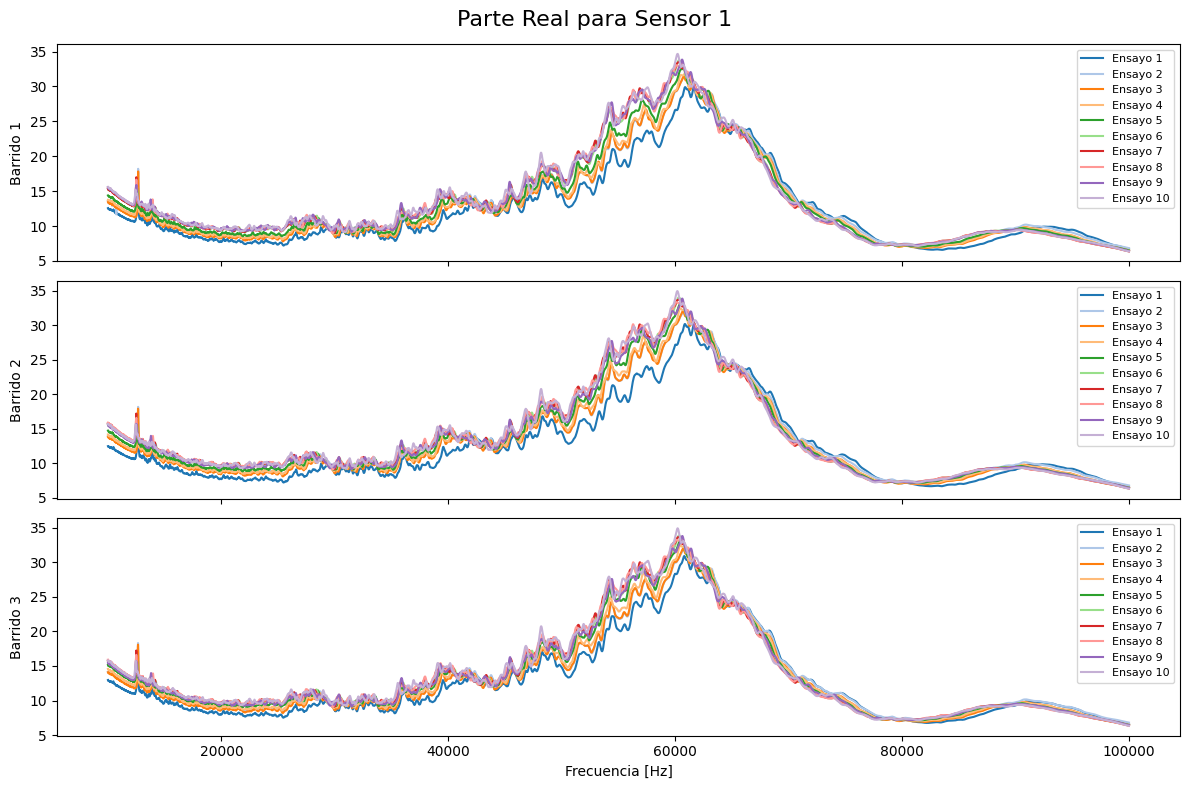

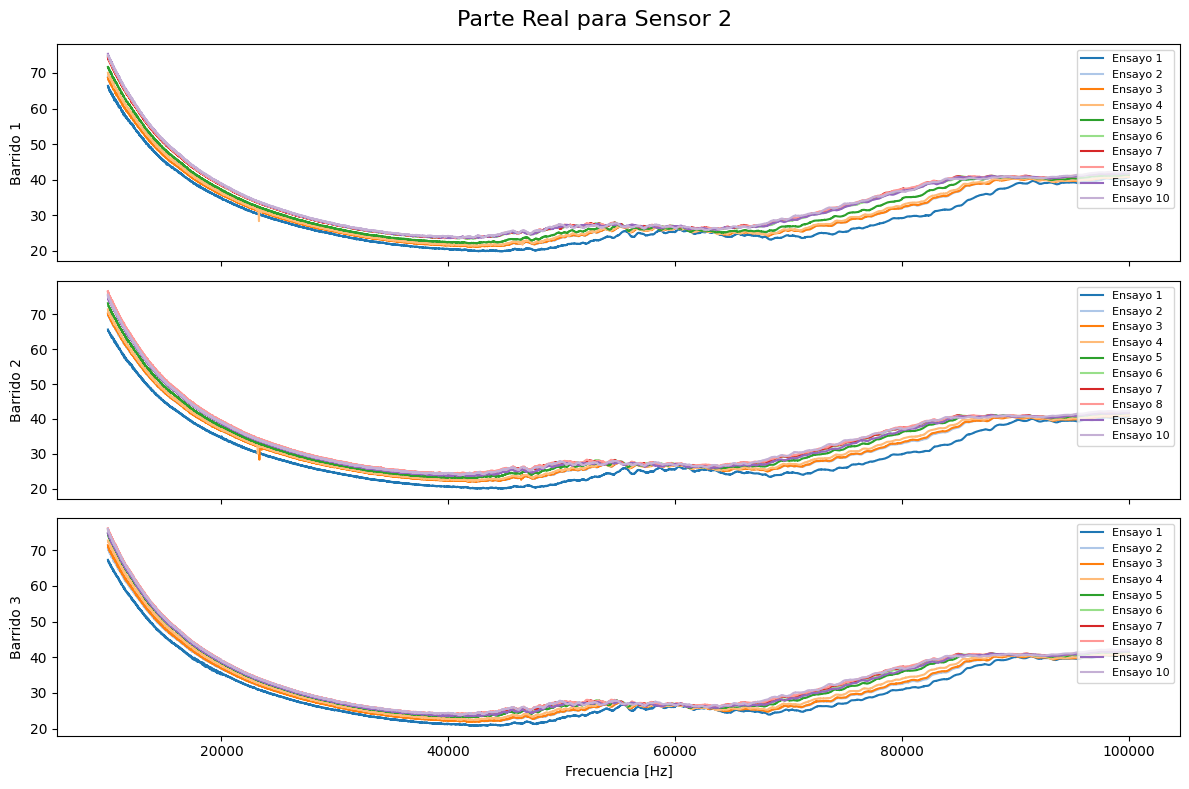

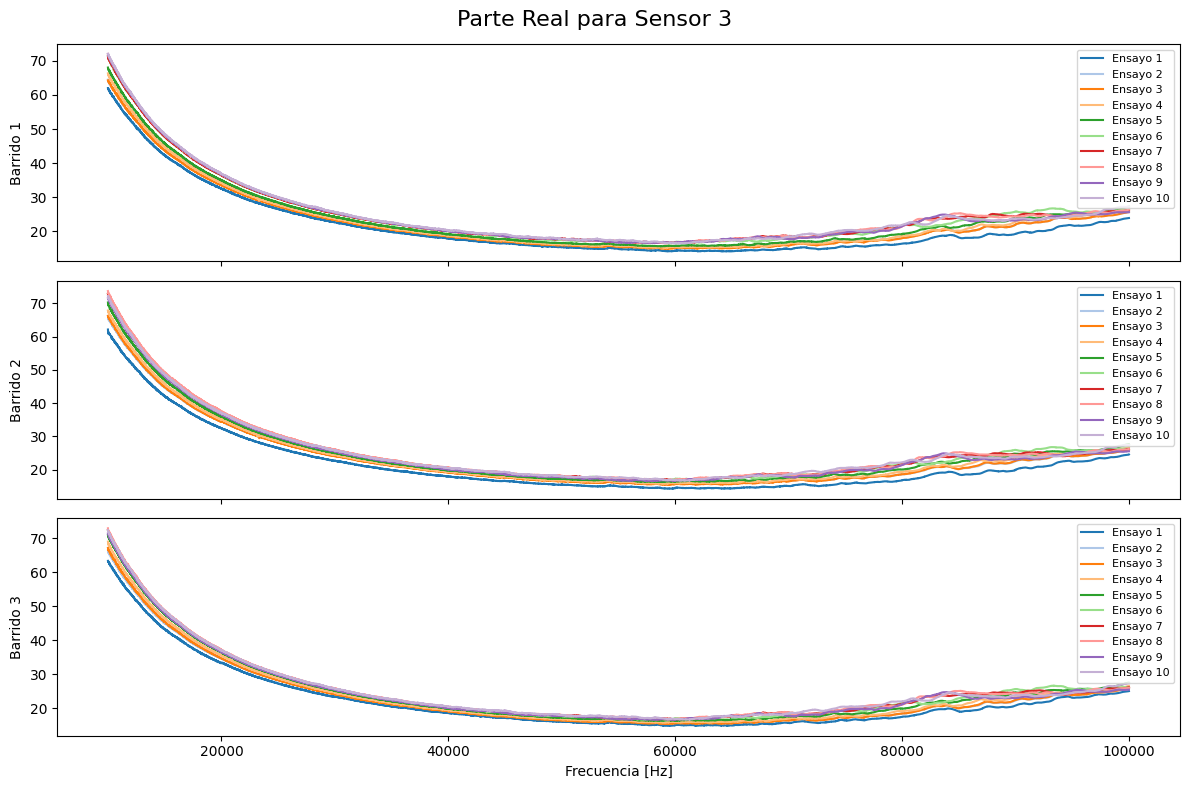

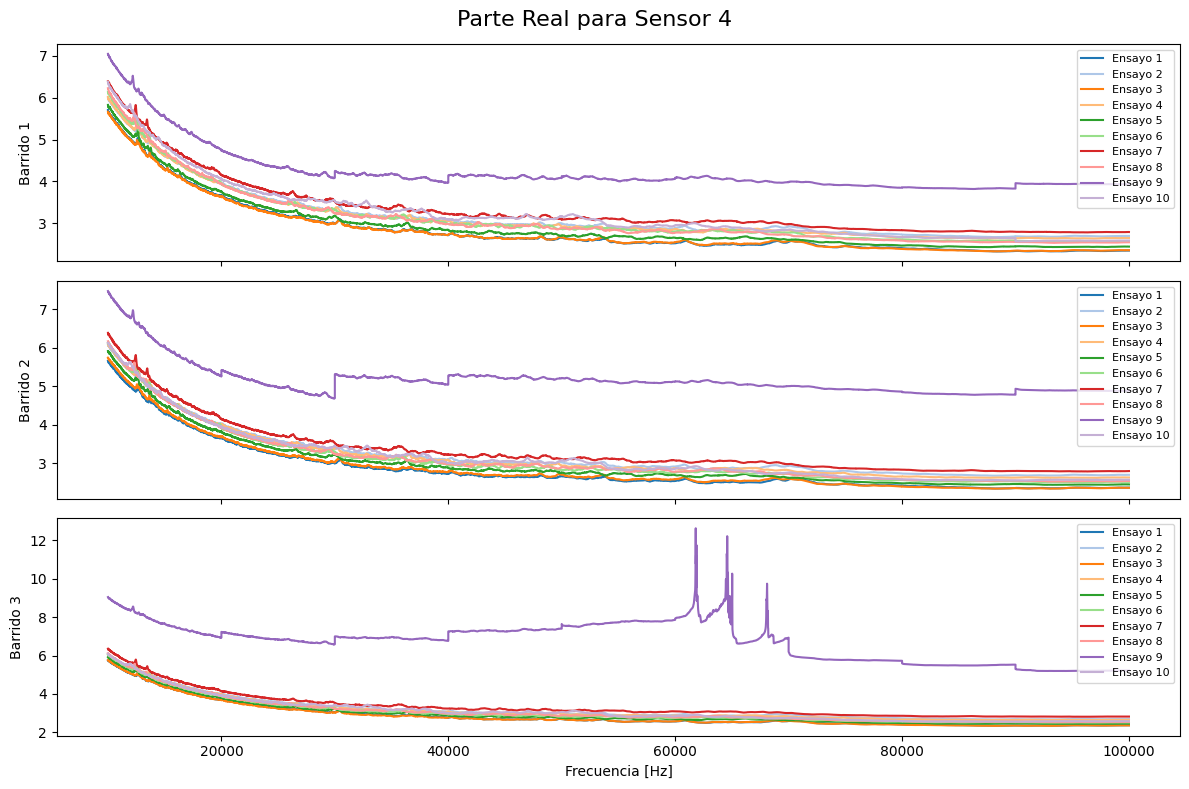

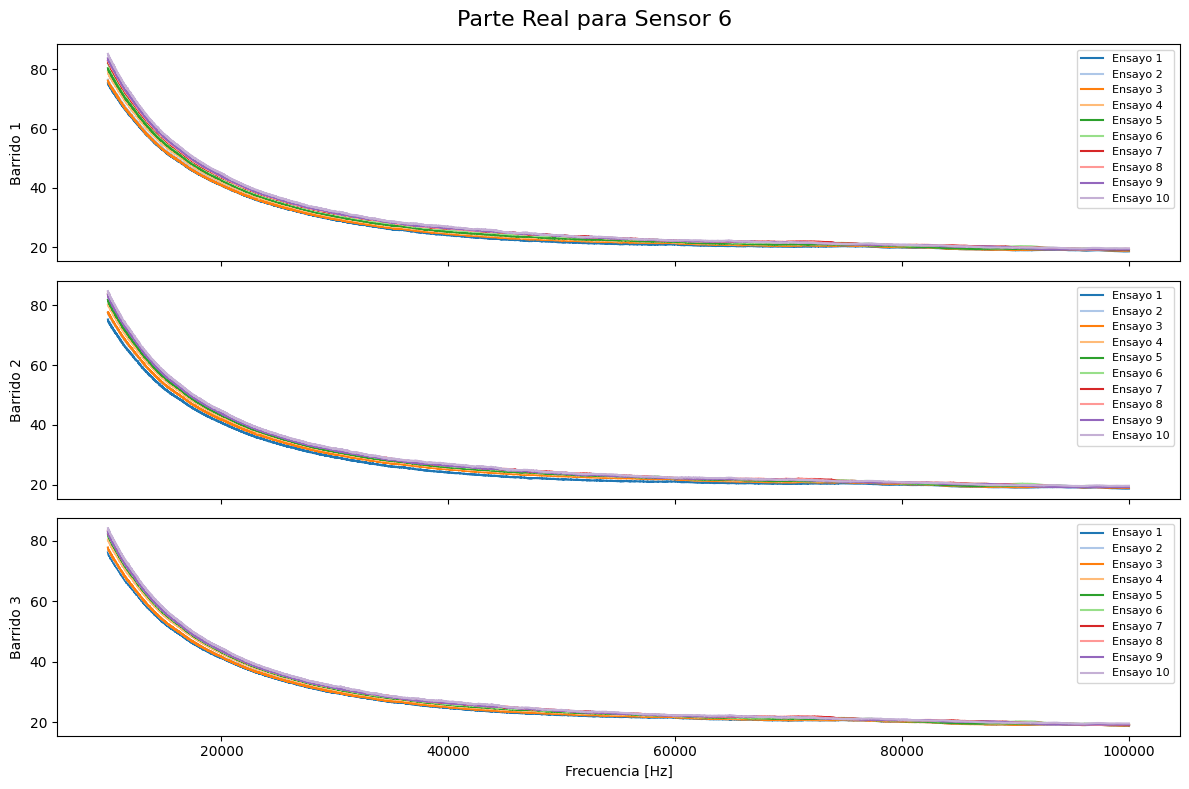

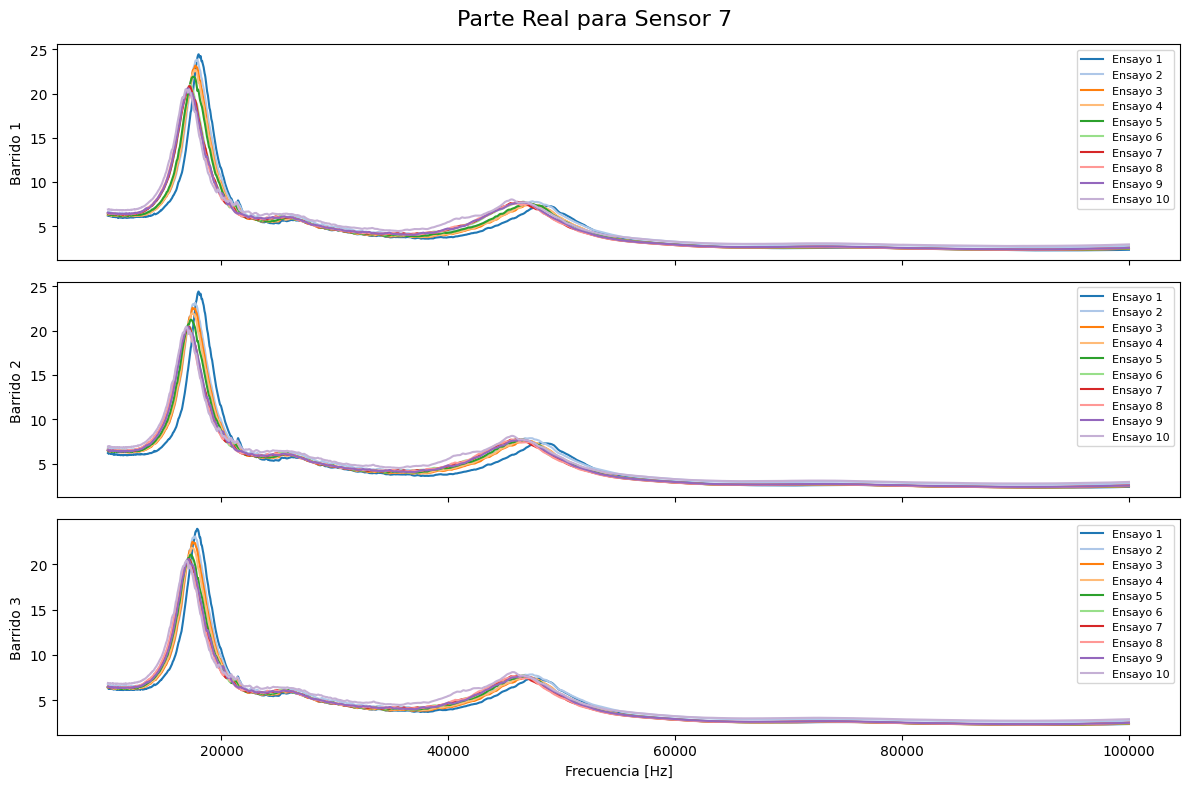

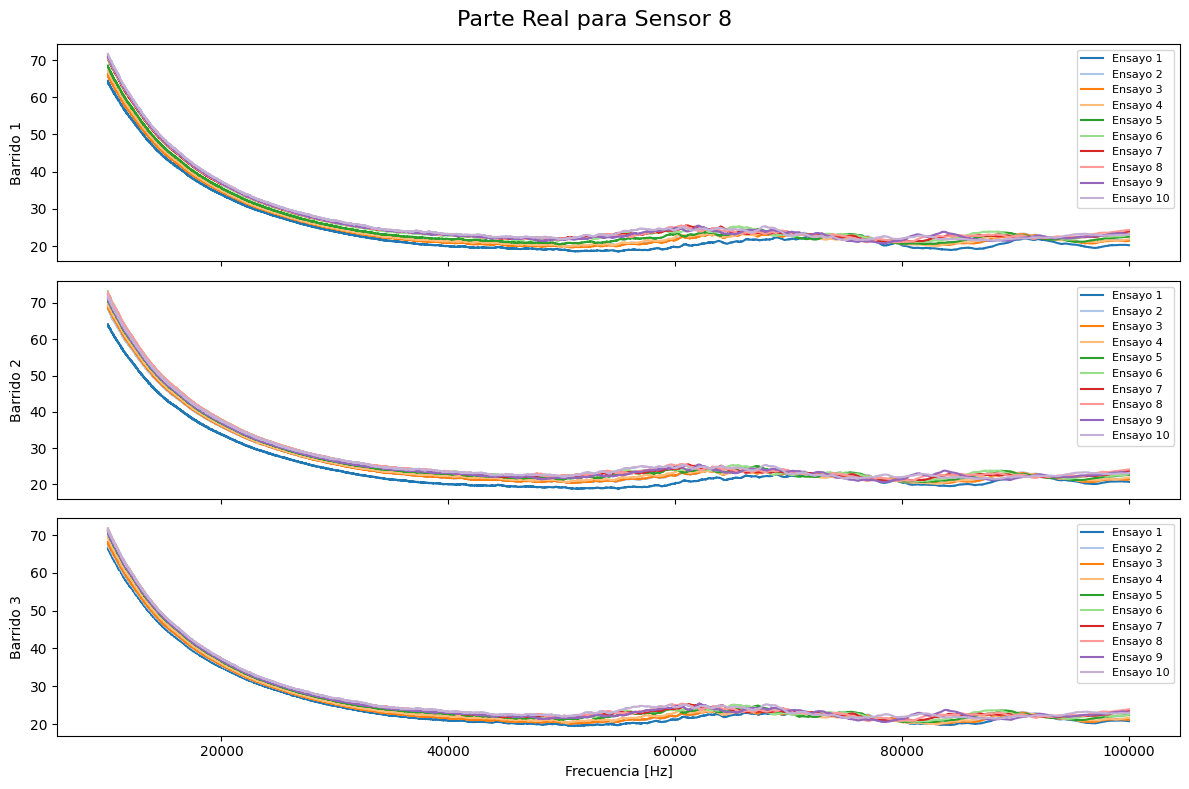

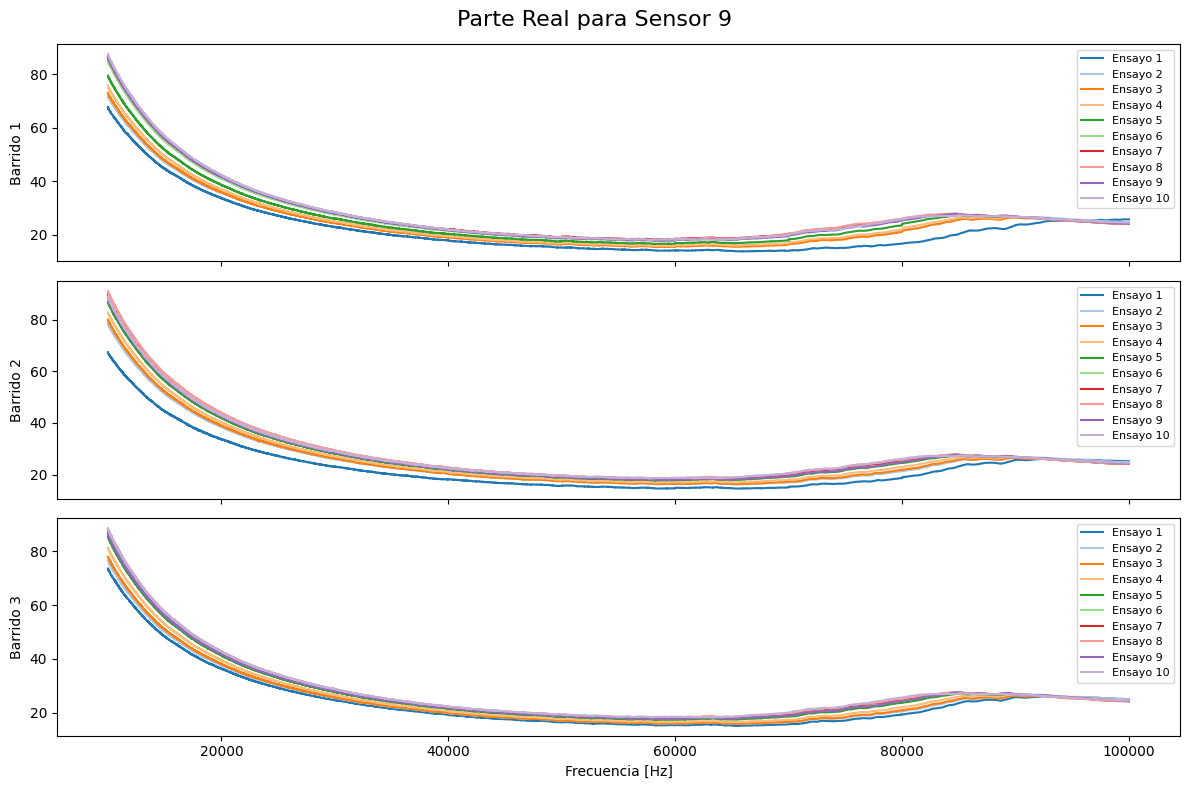

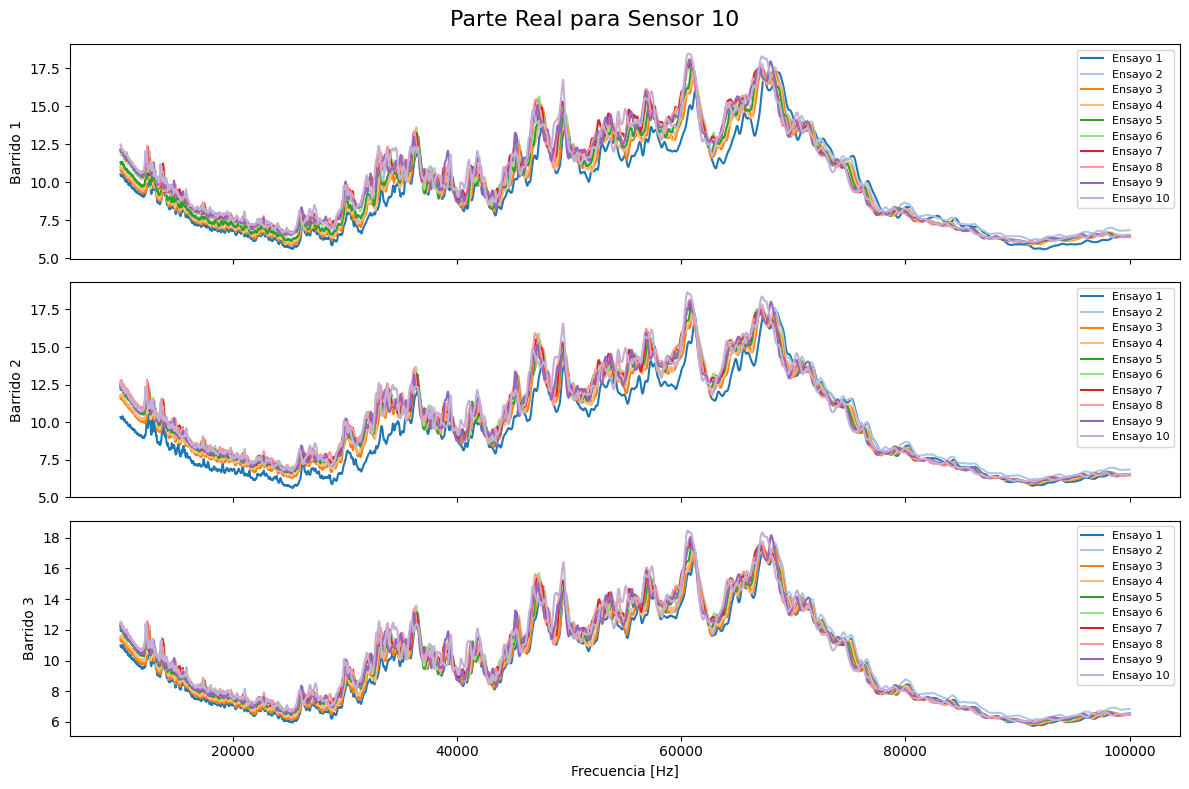

In [7]:
#VISUALIZACIÓN DE SEÑALES: Subplots de las señales separados por sensor, carga y sensor-barrido
n_ensayos, n_barridos, n_sensores, n_puntos = (10, 3, 9, 7209)
colormap = plt.get_cmap("tab20")
# Parte real
for sensor in range(n_sensores):
    fig, axs = plt.subplots(n_barridos, 1, figsize=(12, 8), sharex=True) # Creamos una figura con n_barridos subplots (uno por cada barrido).
    if sensor<4:
        fig.suptitle(f"Parte Real para Sensor {sensor+1}", fontsize=16)
    else: fig.suptitle(f"Parte Real para Sensor {sensor+2}", fontsize=16)
    
    # Iteramos sobre cada barrido
    for barrido in range(n_barridos):
        ax = axs[barrido]  
        for ensayo in range(n_ensayos):
            color = colormap(ensayo % 20)
            ax.plot(data_frecuencias_np_vis,data_partes_reales_np_vis[ensayo, barrido, sensor], label=f"Ensayo {ensayo+1}", color=color)
        
        ax.set_ylabel(f"Barrido {barrido+1}")
        ax.legend(fontsize=8, loc="upper right")
    
    axs[-1].set_xlabel("Frecuencia [Hz]")
    plt.tight_layout()
    plt.show()

In [8]:
data_partes_reales_np_reshaped=data_partes_reales_np.reshape(10, 3, 9, 81, 89)
data_partes_reales_np_reshaped.shape

(10, 3, 9, 81, 89)

In [9]:
data_partes_imagin_np_reshaped=data_partes_imagin_np.reshape(10, 3, 9, 81, 89)
data_partes_imagin_np_reshaped.shape

(10, 3, 9, 81, 89)

In [10]:
data_partes_reales_tensor = torch.tensor(data_partes_reales_np_reshaped, dtype=torch.float32)
data_partes_imagin_tensor = torch.tensor(data_partes_imagin_np_reshaped, dtype=torch.float32)
freqs_tensor = torch.tensor(data_frecuencias_np_vis, dtype=torch.float32)
torch.save(data_partes_reales_tensor, 'tensor_emis_real_corto.pt')
torch.save(data_partes_imagin_tensor, 'tensor_emis_imagin_corto.pt')
torch.save(freqs_tensor, 'freqs_emis_corto.pt')

In [11]:
data_partes_reales_tensor=torch.load('tensor_emis_real_corto.pt')
data_partes_imagin_tensor=torch.load('tensor_emis_imagin_corto.pt')
freqs_tensor=torch.load('freqs_emis_corto.pt')


# Definición del Autoencoder Variacional (VAE)
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 3, stride=2, padding=2),
            nn.ReLU()
        )
        
       # Obtener tamaño de salida del encoder dinámicamente
        with torch.no_grad():
            sample_input = torch.randn(1, 1, 89)
            sample_output = self.encoder(sample_input)
            encoded_dim = sample_output.numel() // sample_output.shape[0]
            print(encoded_dim)

        self.fc_mu = nn.Linear(encoded_dim, latent_dim)
        self.fc_logvar = nn.Linear(encoded_dim, latent_dim)
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, encoded_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 64, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, 3, stride=2, padding=2),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplanamos
        #print(f"Tamaño después del encoder: {x.shape}")  # Depuración
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        x = self.decoder_fc(z).view(x.size(0), 64, -1)
        x = self.decoder(x)
        return x, mu, logvar

In [12]:
print(data_partes_reales_tensor.shape)
print(data_partes_imagin_tensor.shape)

torch.Size([10, 3, 9, 81, 89])
torch.Size([10, 3, 9, 81, 89])


In [13]:
latent_dim=4
model = VariationalAutoencoder(latent_dim)
summary(model, input_size=(64, 1, 89))

256


Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoencoder                   [64, 1, 89]               --
├─Sequential: 1-1                        [64, 64, 4]               --
│    └─Conv1d: 2-1                       [64, 16, 46]              64
│    └─ReLU: 2-2                         [64, 16, 46]              --
│    └─Conv1d: 2-3                       [64, 16, 24]              784
│    └─ReLU: 2-4                         [64, 16, 24]              --
│    └─Conv1d: 2-5                       [64, 32, 13]              1,568
│    └─ReLU: 2-6                         [64, 32, 13]              --
│    └─Conv1d: 2-7                       [64, 32, 8]               3,104
│    └─ReLU: 2-8                         [64, 32, 8]               --
│    └─Conv1d: 2-9                       [64, 64, 5]               6,208
│    └─ReLU: 2-10                        [64, 64, 5]               --
│    └─Conv1d: 2-11                      [64, 64, 4]               12,352
│

In [27]:
learning_rate = 1e-3 # Determina qué tan grandes son los ajustes en los parámetros del modelo después de cada lote o época.
batch_size = 64 # Es la cantidad de datos que se pasan por la red antes de actualizar los parámetros
epochs = 100 # Una época es una pasada completa por todo el dataset de entrenamiento
def loss_fn(outputs, inputs, mu, logvar,beta=0.05):
    mse = (outputs - inputs) ** 2  # Calcula el error cuadrático

    # Reducción lotes/muestras con mean
    loss_0= torch.mean(mse, dim=0)
    
    # Reducción secuencia/longitud con sum
    loss_2 = torch.sum(mse, dim=2)
    
    recon_loss = torch.sum(loss_2) + torch.sum(loss_0)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_divergence
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
# baseline=data_partes_reales_tensor[[0]]
# print(baseline.shape)
# loads=data_partes_reales_tensor[1:]
# print(loads.shape)

In [29]:
def scale_signal(signal):
    # signal: tensor [num_channels, sequence_length] o [batch, L]
    min_val = signal.min(dim=-1, keepdim=True)[0]
    max_val = signal.max(dim=-1, keepdim=True)[0]
    scaled = (signal - min_val) / (max_val - min_val + 1e-8)
    return scaled

In [30]:
# Preparar los datos para DataLoader
# Reestructurar los tensores para que tengan la forma [num_samples, num_channels, sequence_length]
loads=data_partes_reales_tensor.view(-1, 1, 89)
data_scaled = scale_signal(loads)

print(data_scaled.shape)

train_dataset = TensorDataset(data_scaled)
test_dataset = TensorDataset(data_scaled)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([21870, 1, 89])


In [31]:
# Entrenamiento del modelo
def train_model(model, train_loader, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            inputs = batch[0]
            outputs, mu, logvar = model(inputs)
            loss = loss_fn(outputs, inputs, mu, logvar)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        print(f"Época {epoch+1}/{epochs}, Pérdida: {epoch_loss / len(train_loader):.6f}")

train_model(model, train_loader, optimizer, epochs)

Época 1/100, Pérdida: 56.934186
Época 2/100, Pérdida: 56.834803
Época 3/100, Pérdida: 56.802024
Época 4/100, Pérdida: 56.615009
Época 5/100, Pérdida: 56.540785
Época 6/100, Pérdida: 56.413844
Época 7/100, Pérdida: 56.408542
Época 8/100, Pérdida: 56.181118
Época 9/100, Pérdida: 56.150982
Época 10/100, Pérdida: 56.092896
Época 11/100, Pérdida: 56.083317
Época 12/100, Pérdida: 55.887821
Época 13/100, Pérdida: 55.729436
Época 14/100, Pérdida: 55.808362
Época 15/100, Pérdida: 55.767644
Época 16/100, Pérdida: 55.660888
Época 17/100, Pérdida: 55.620040
Época 18/100, Pérdida: 55.491185
Época 19/100, Pérdida: 55.474783
Época 20/100, Pérdida: 55.452159
Época 21/100, Pérdida: 55.300946
Época 22/100, Pérdida: 55.254515
Época 23/100, Pérdida: 55.319955
Época 24/100, Pérdida: 55.109001
Época 25/100, Pérdida: 55.167015
Época 26/100, Pérdida: 55.012632
Época 27/100, Pérdida: 54.903405
Época 28/100, Pérdida: 54.909916
Época 29/100, Pérdida: 54.805116
Época 30/100, Pérdida: 54.820389
Época 31/100, Pérdi

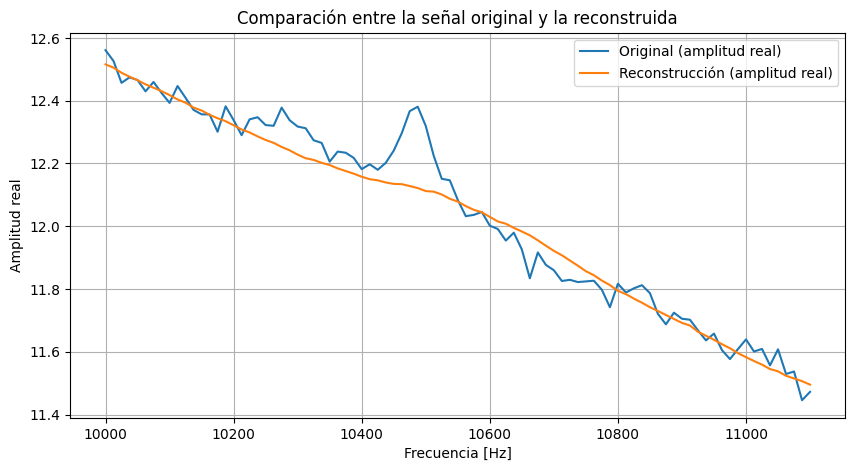

In [32]:
def evaluate_model(model, loads_scaled, loads_original, freqs_tensor):

    model.eval()
    with torch.no_grad():
        # Tomamos la primera señal (index 0)
        original_signal_scaled = loads_scaled[0]       # [1, 89]
        original_signal_real = loads_original[0]       # [1, 89]

        # Extraer las frecuencias correspondientes a esa señal
        freqs_signal = freqs_tensor[:original_signal_real.shape[-1]]  # primeros 89 valores

        # Reconstrucción
        reconstructed_scaled = model(original_signal_scaled.unsqueeze(0))[0].squeeze().detach()

        # Desnormalizar usando min y max de la señal real
        min_val = original_signal_real.min()
        max_val = original_signal_real.max()
        reconstructed_real = reconstructed_scaled * (max_val - min_val) + min_val

        # Graficar
        plt.figure(figsize=(10, 5))
        plt.plot(freqs_signal.numpy(), original_signal_real.squeeze().numpy(), label="Original (amplitud real)")
        plt.plot(freqs_signal.numpy(), reconstructed_real.numpy(), label="Reconstrucción (amplitud real)")
        plt.legend()
        plt.title("Comparación entre la señal original y la reconstruida")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Amplitud real")
        plt.grid(True)
        plt.show()

# Ejemplo de uso
evaluate_model(model, data_scaled, loads, freqs_tensor)


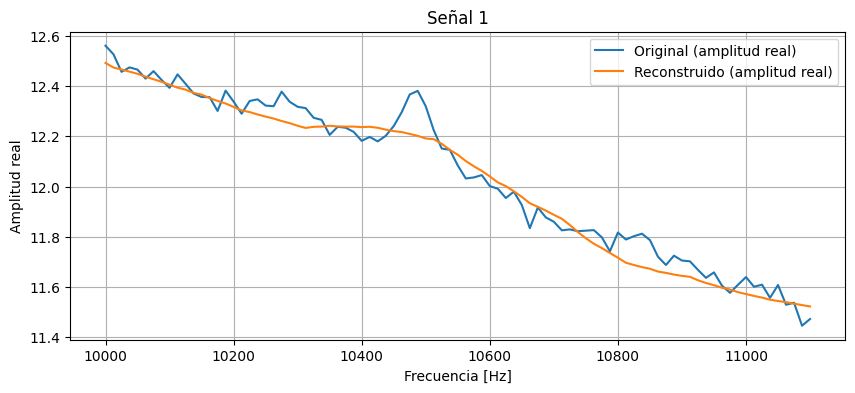

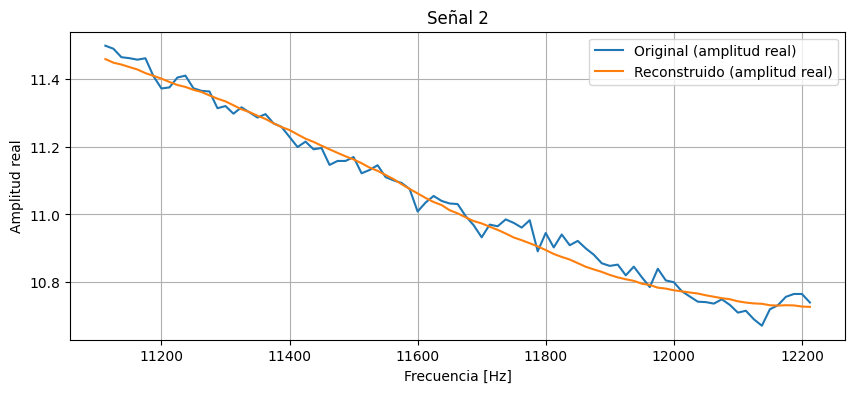

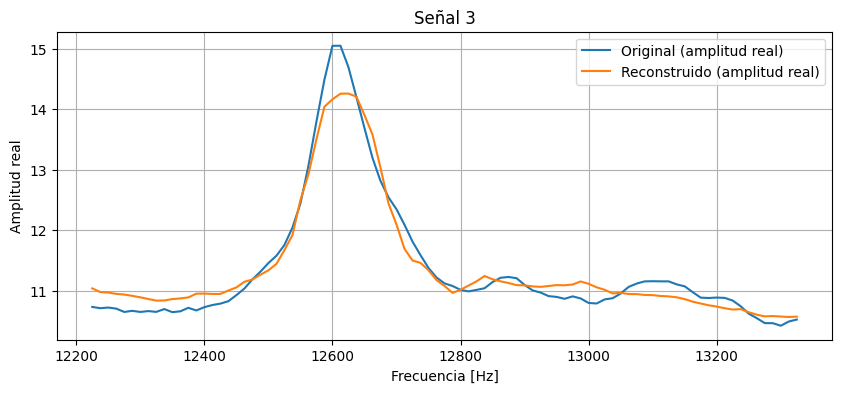

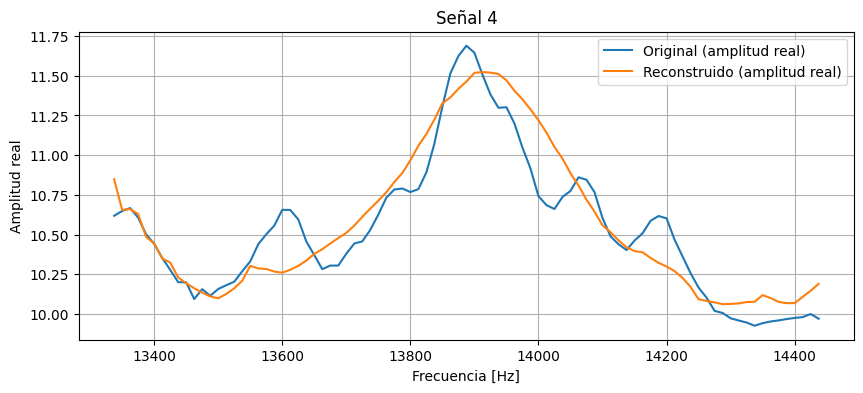

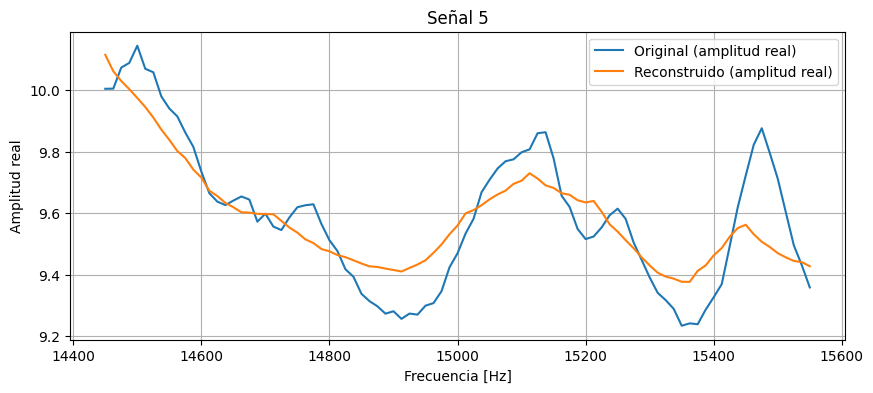

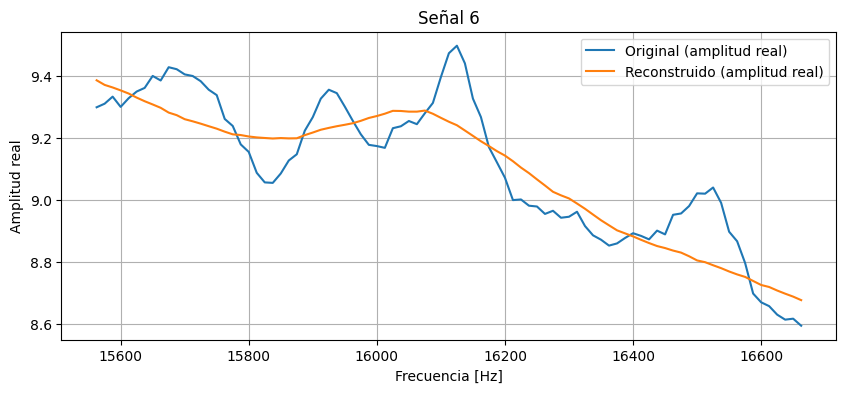

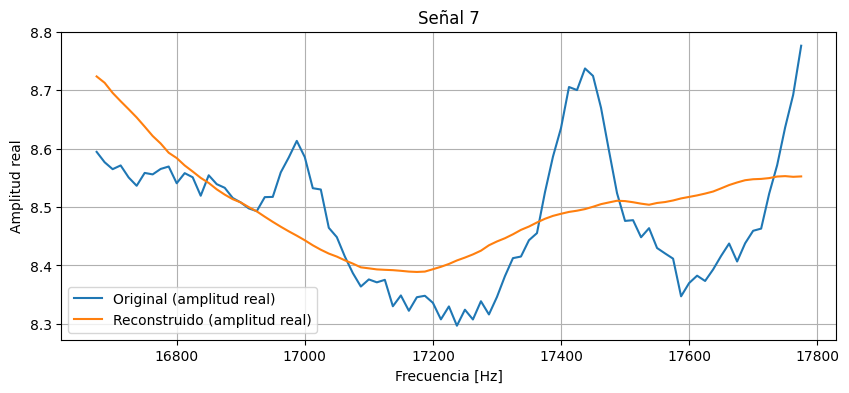

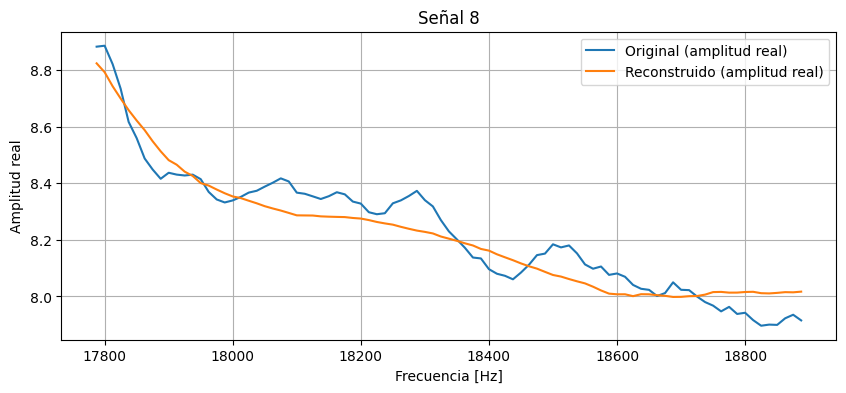

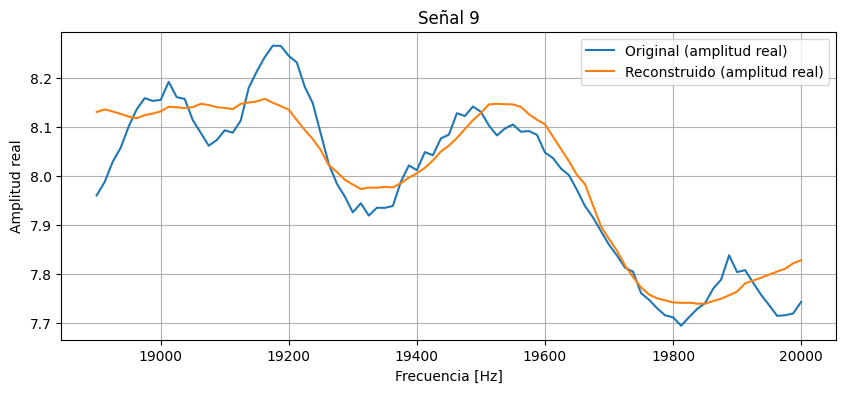

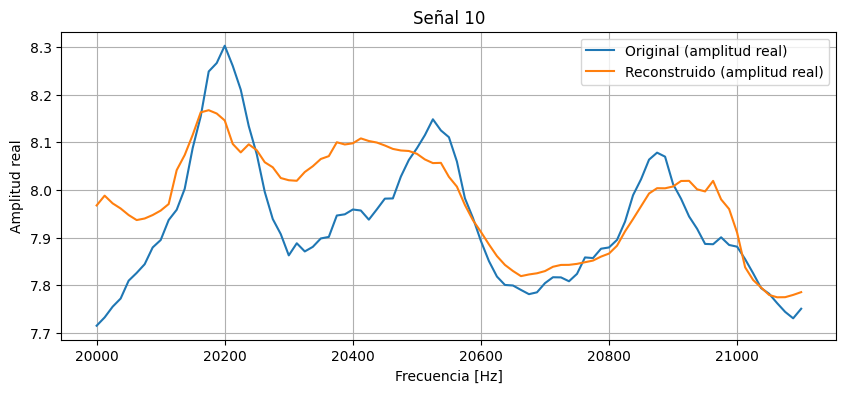

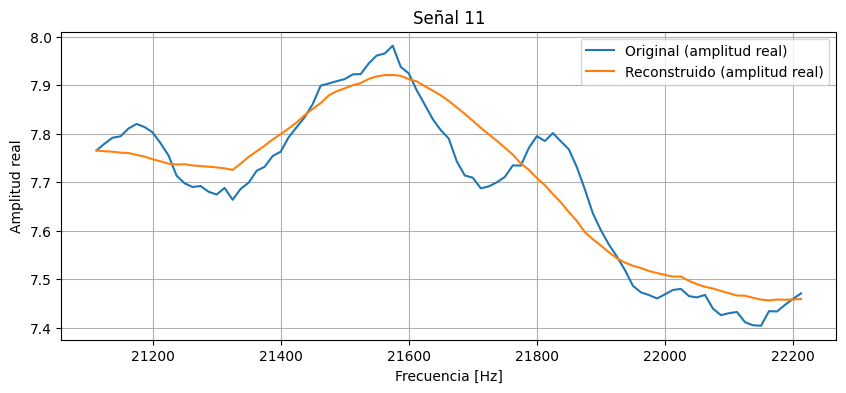

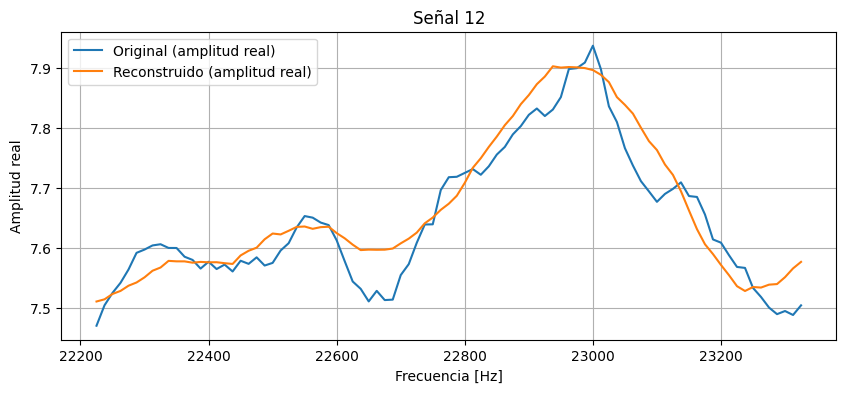

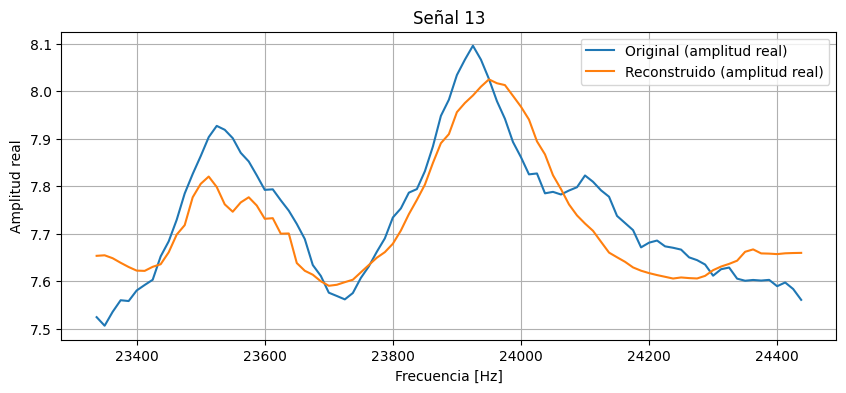

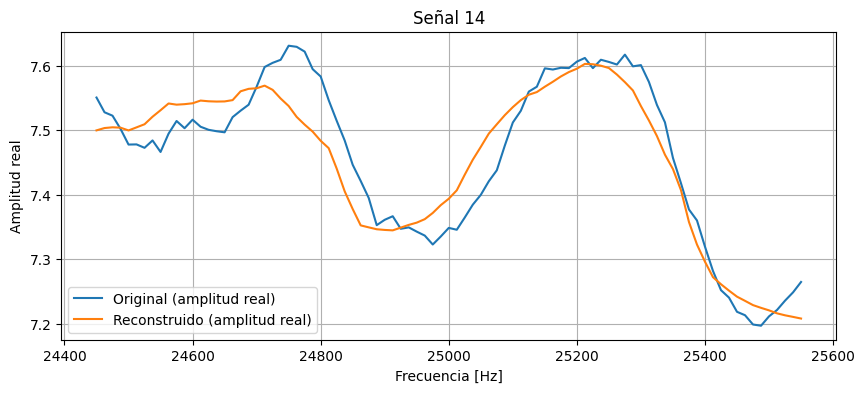

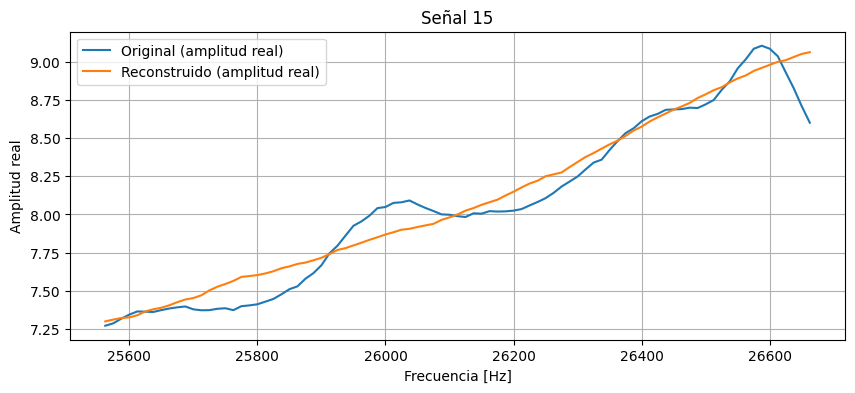

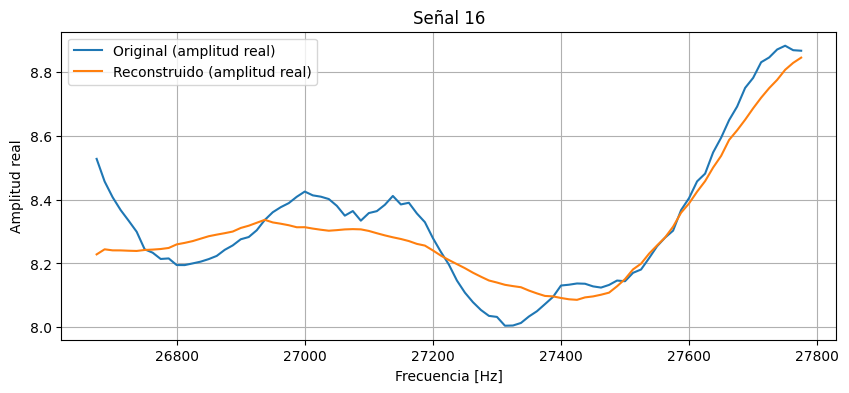

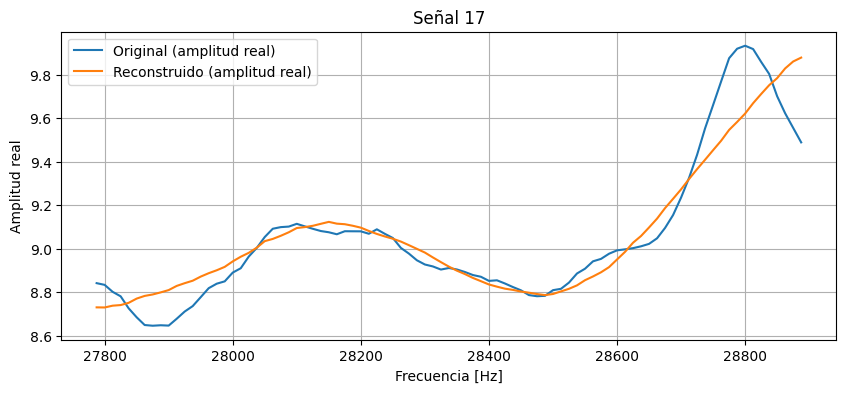

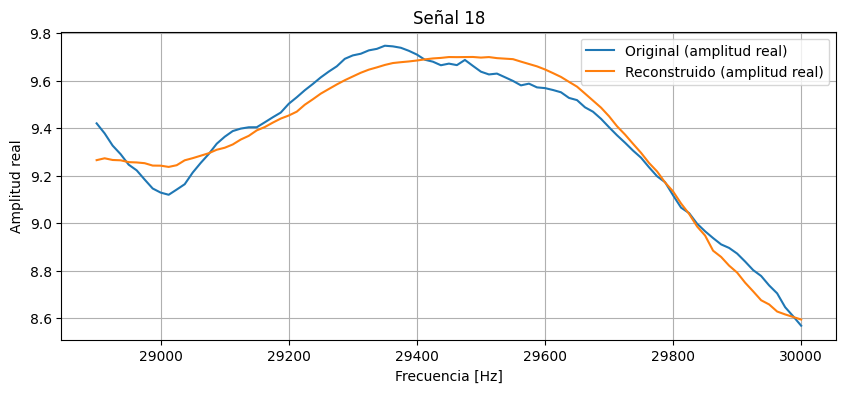

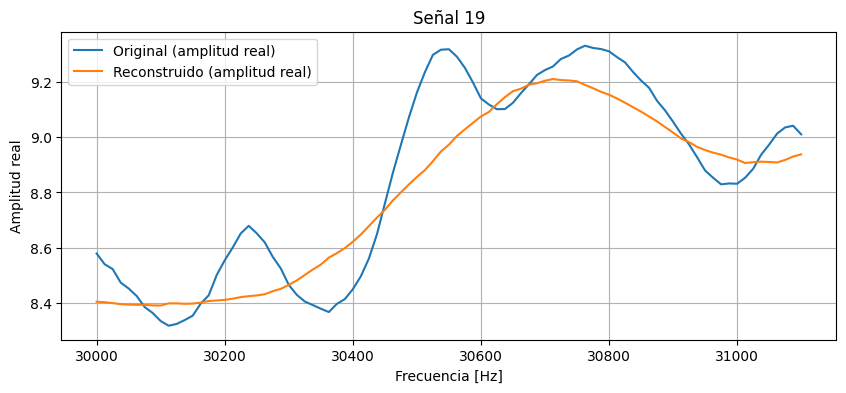

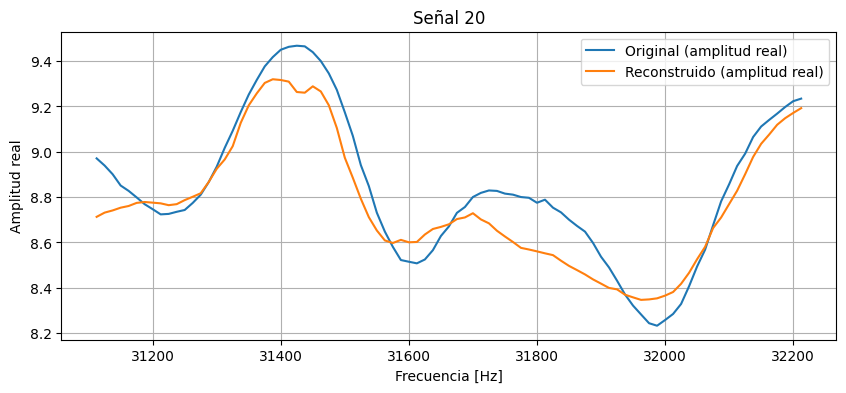

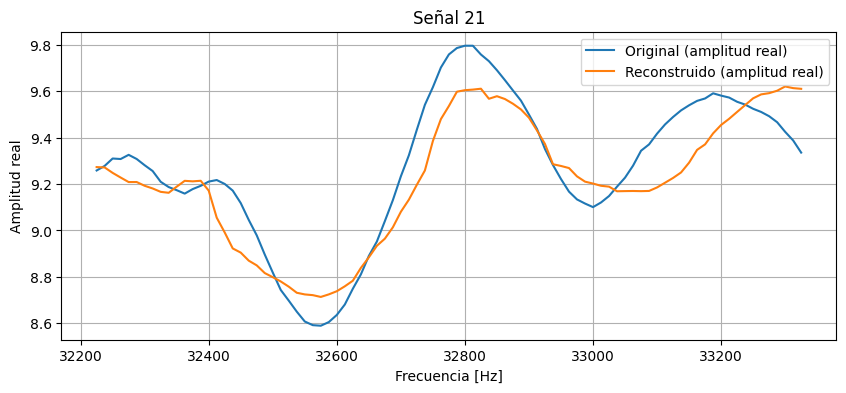

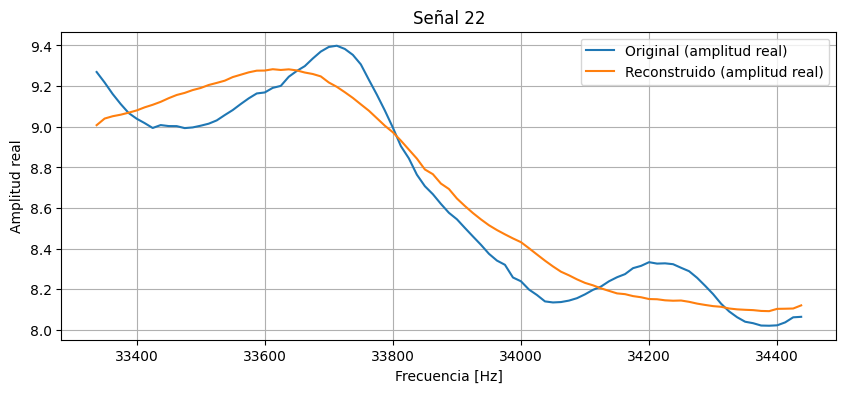

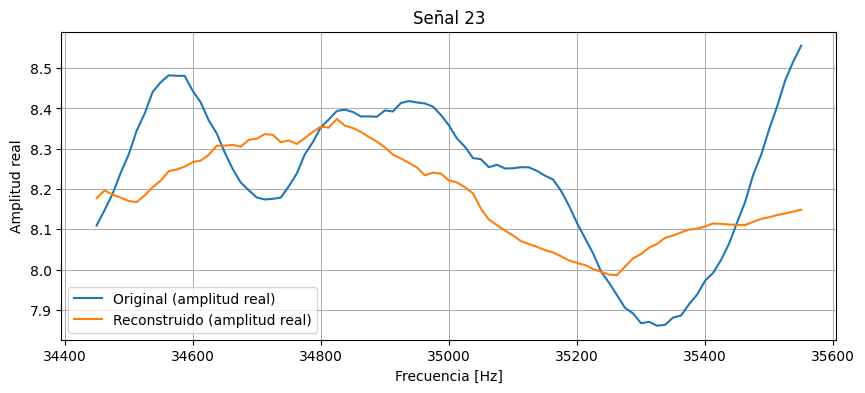

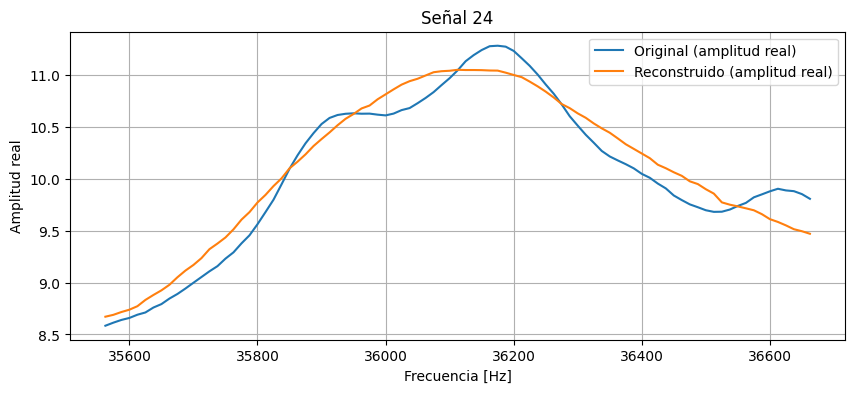

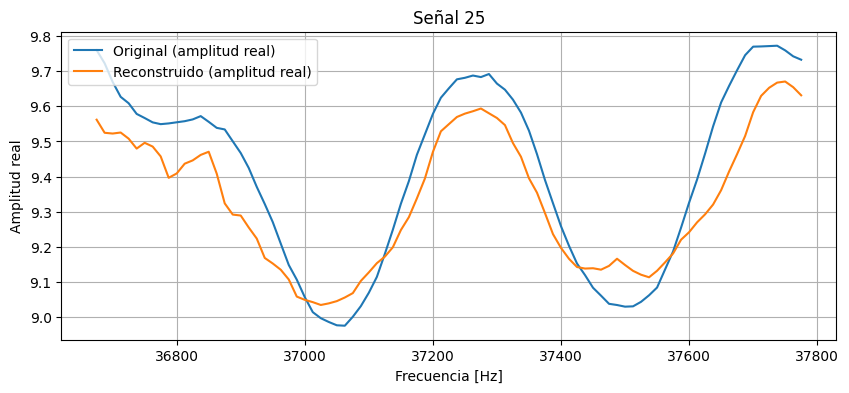

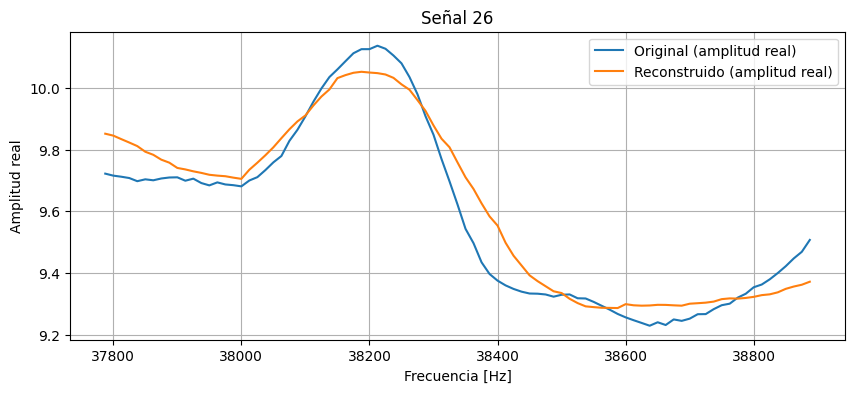

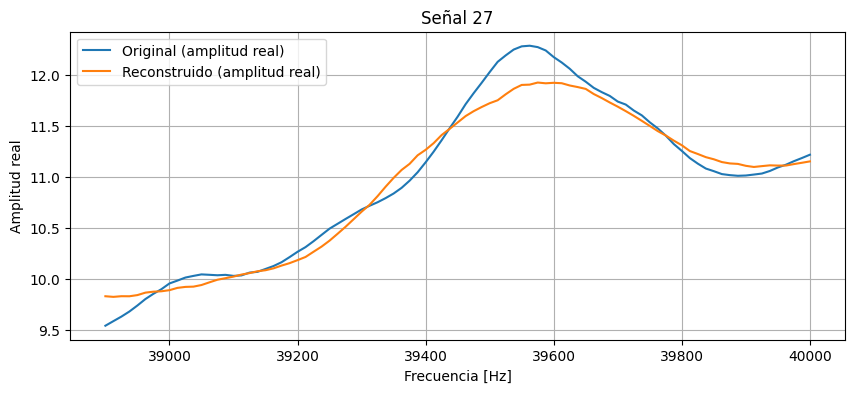

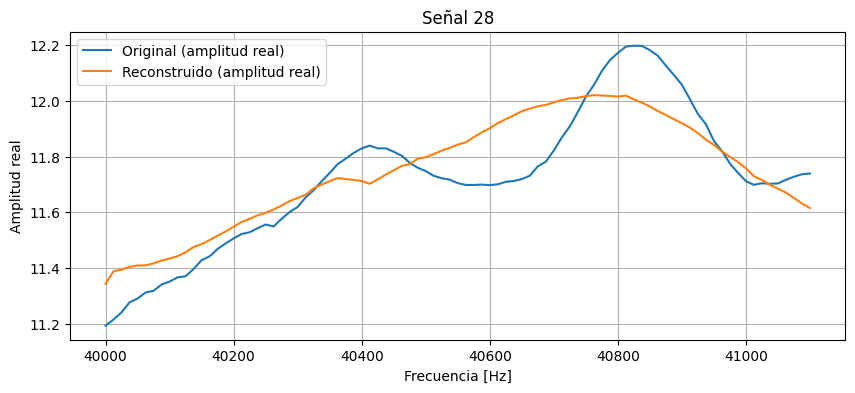

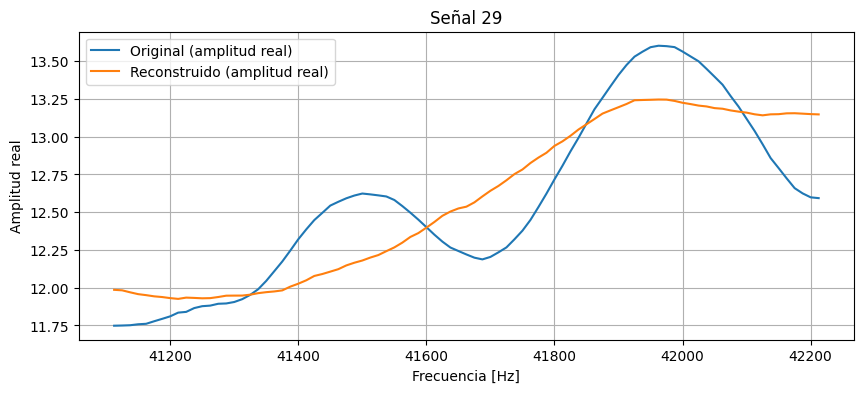

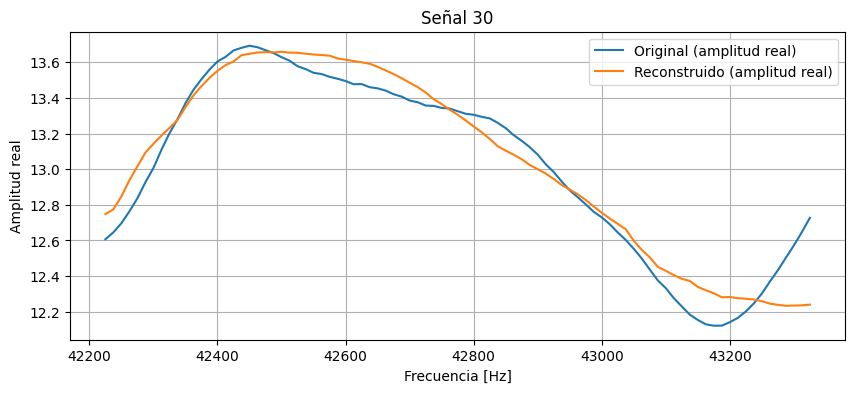

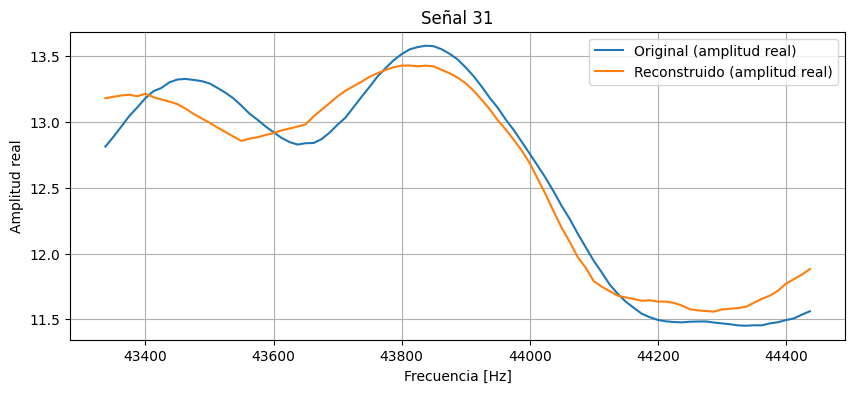

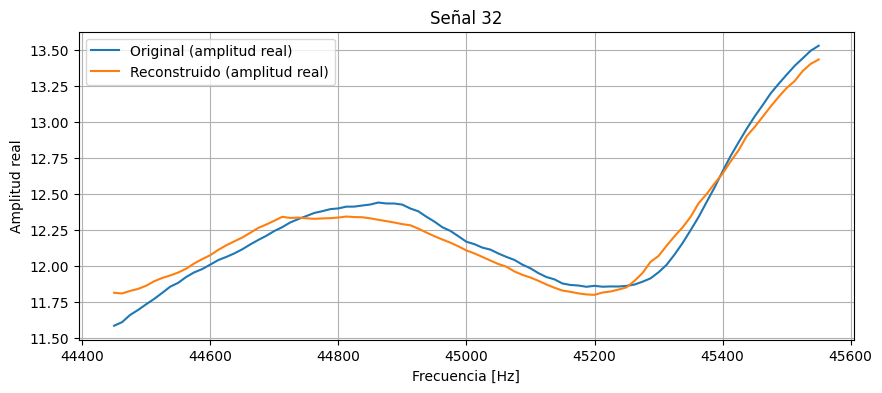

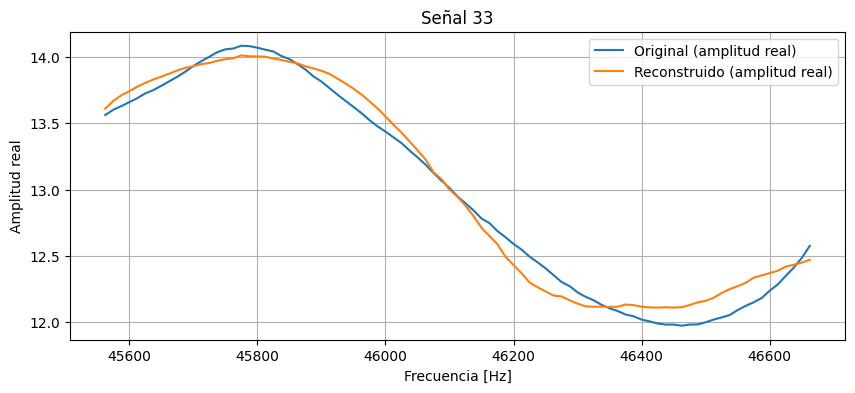

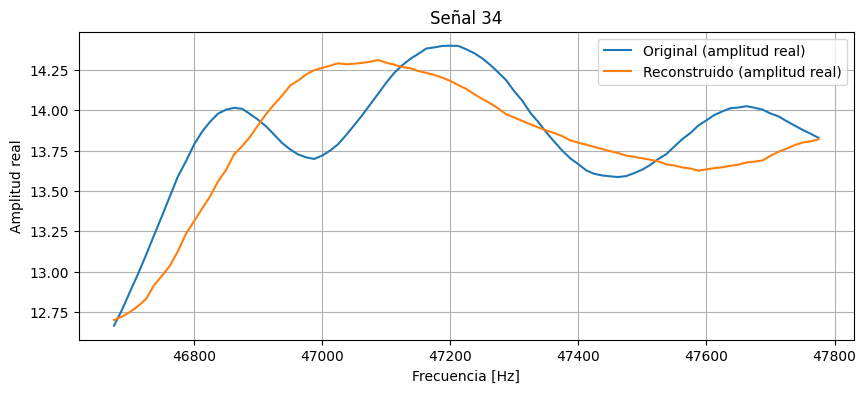

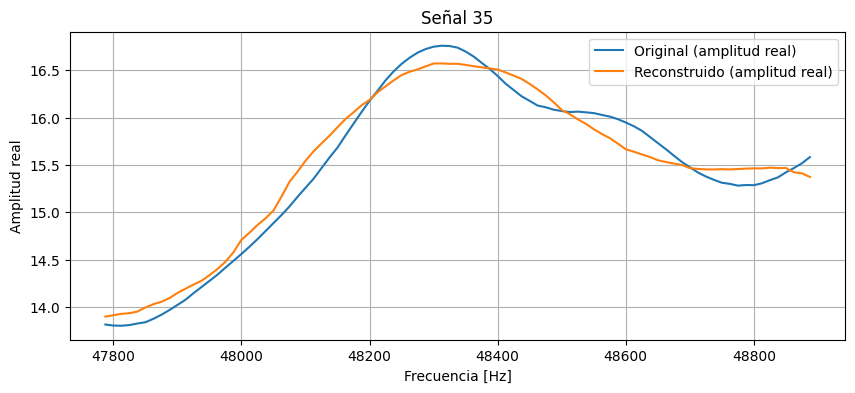

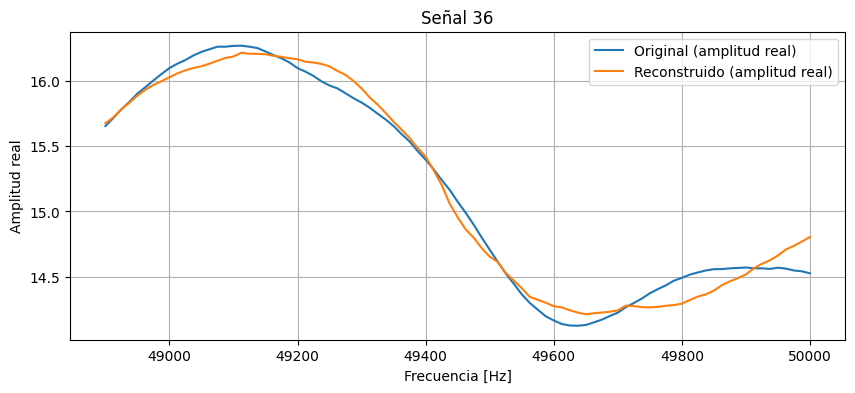

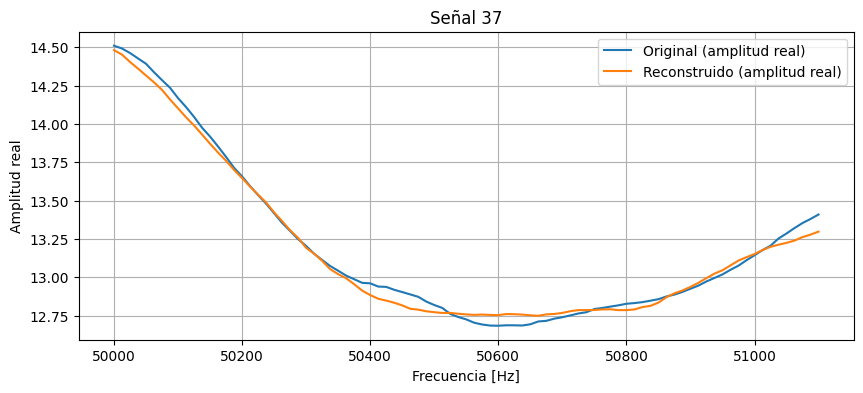

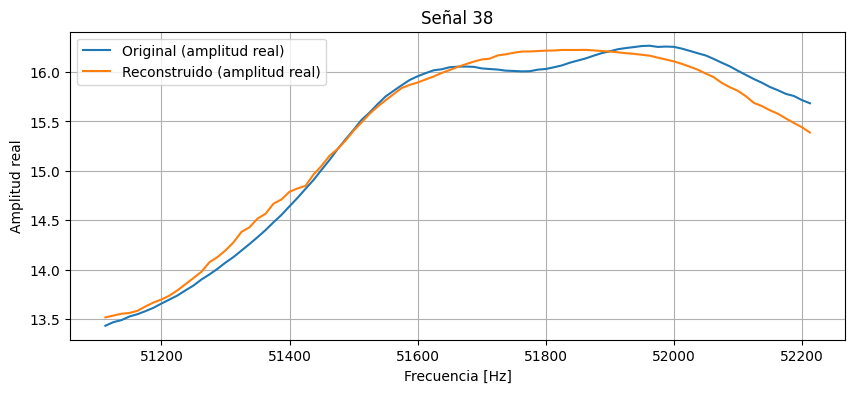

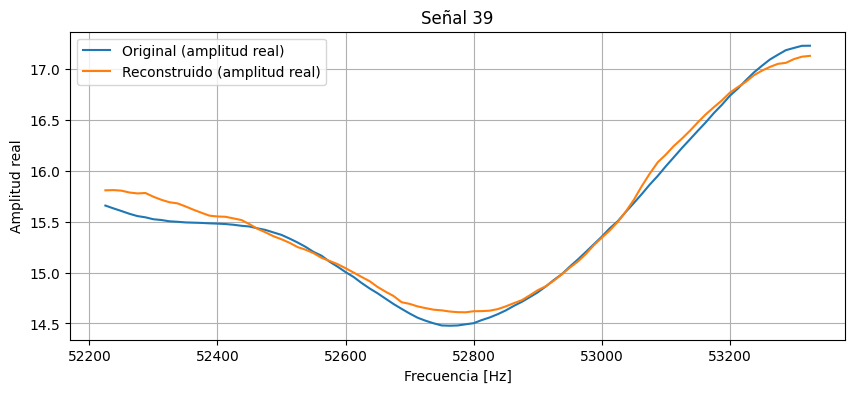

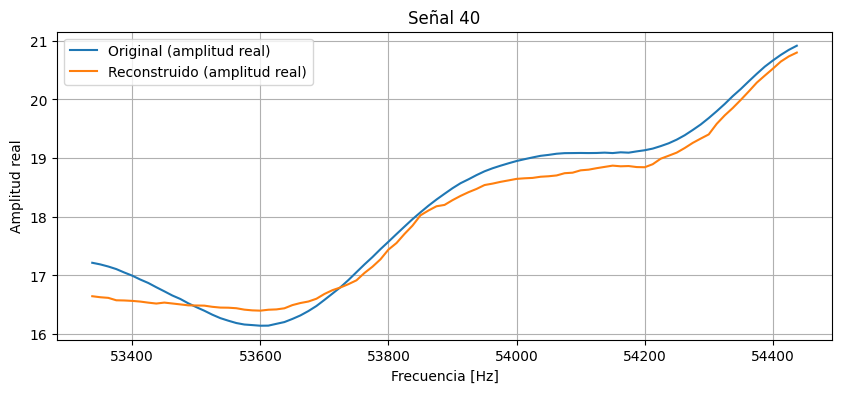

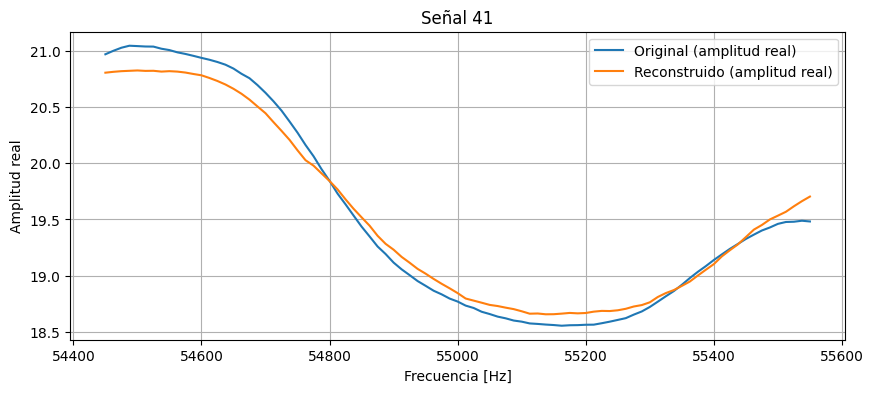

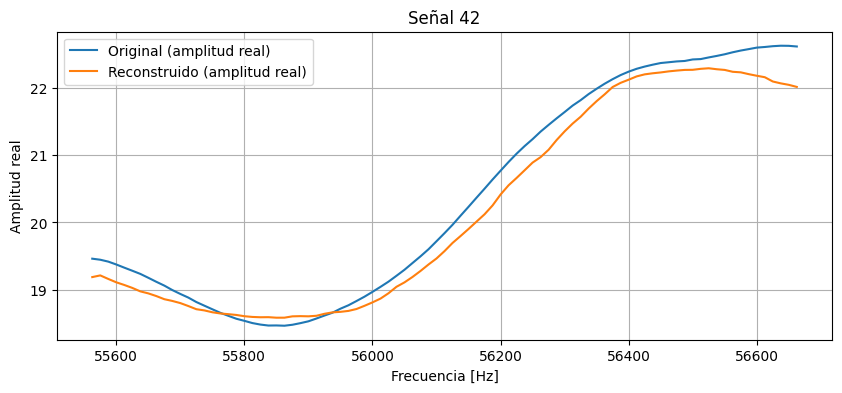

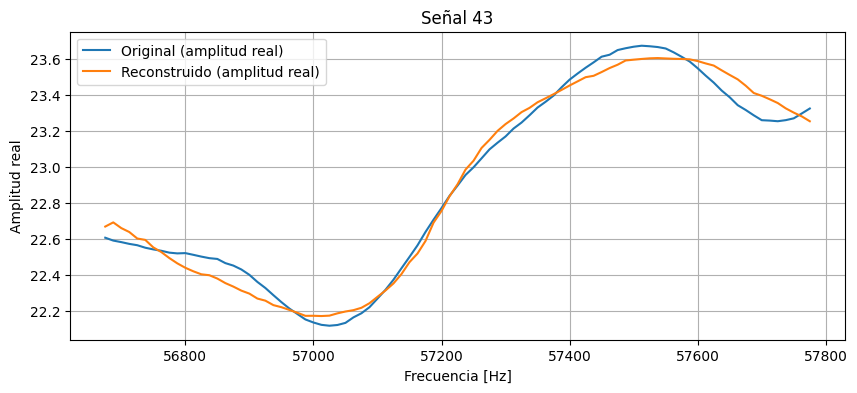

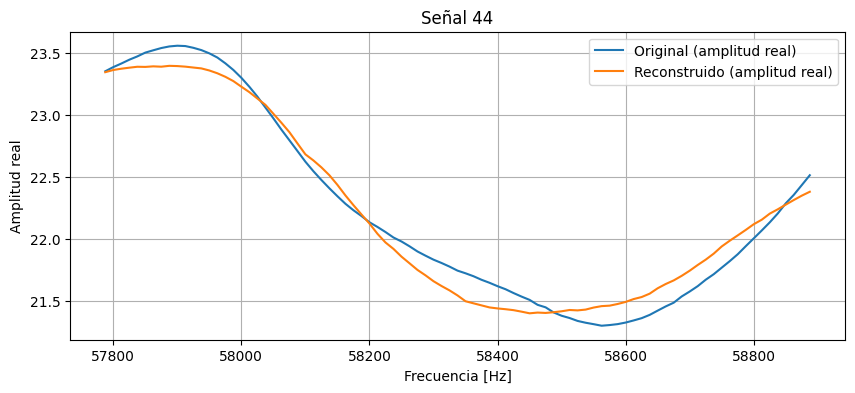

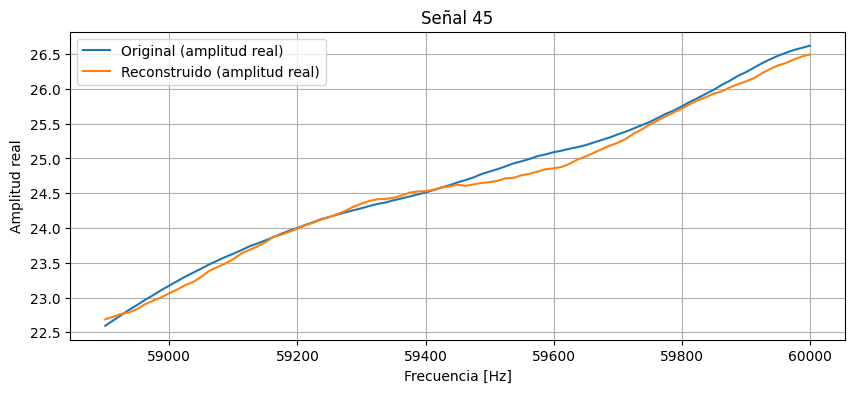

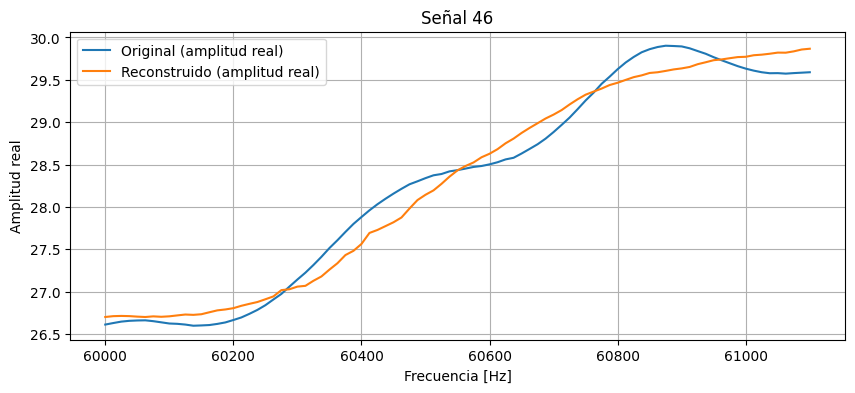

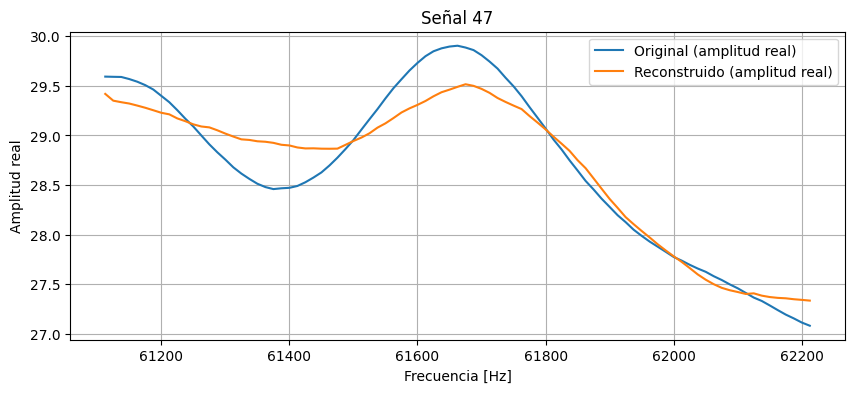

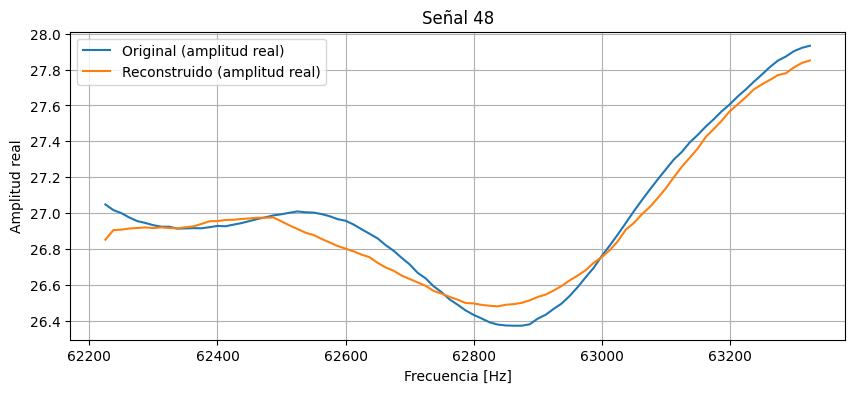

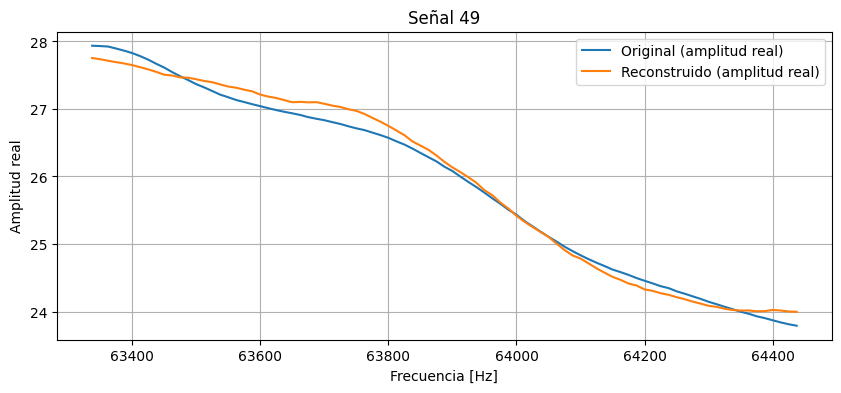

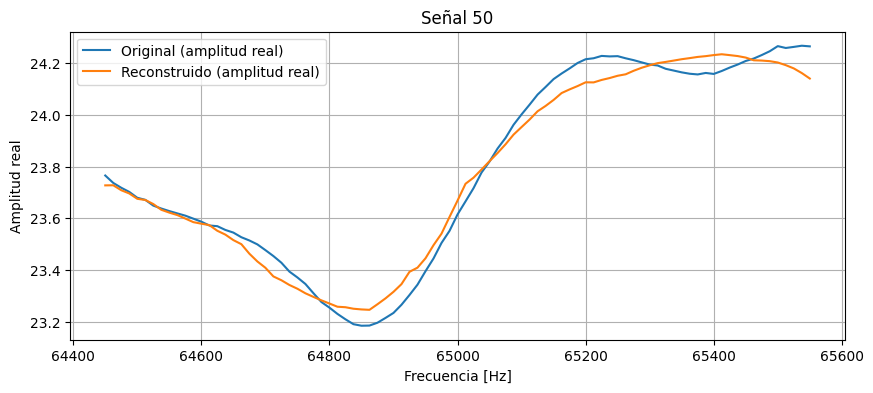

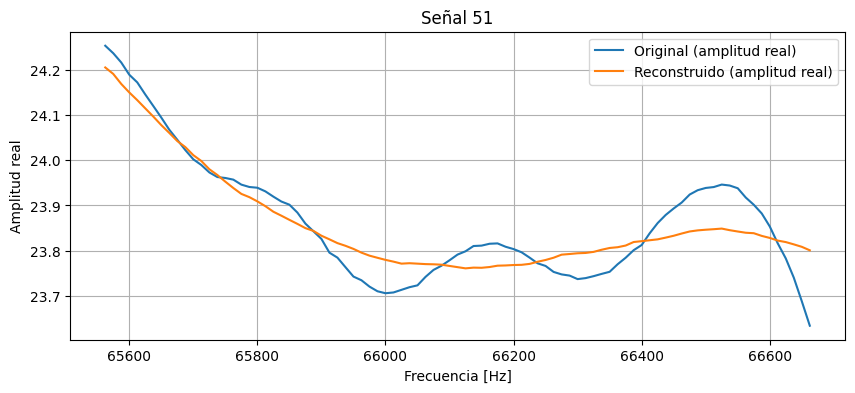

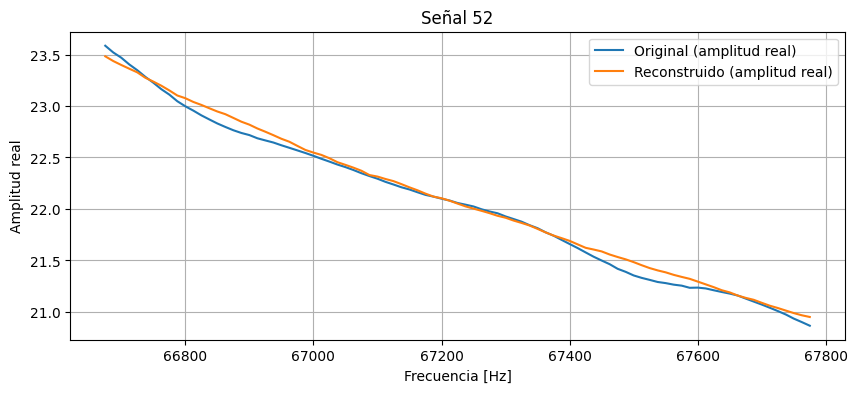

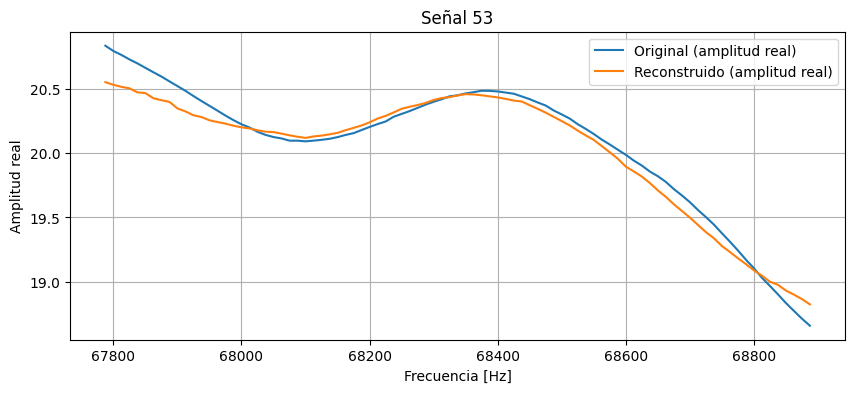

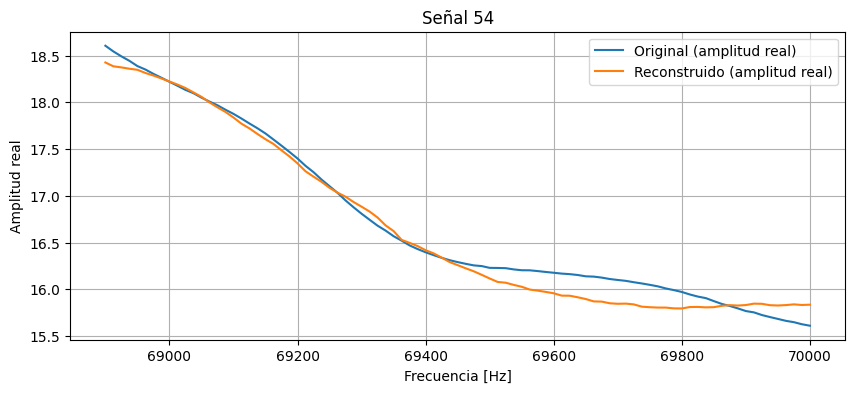

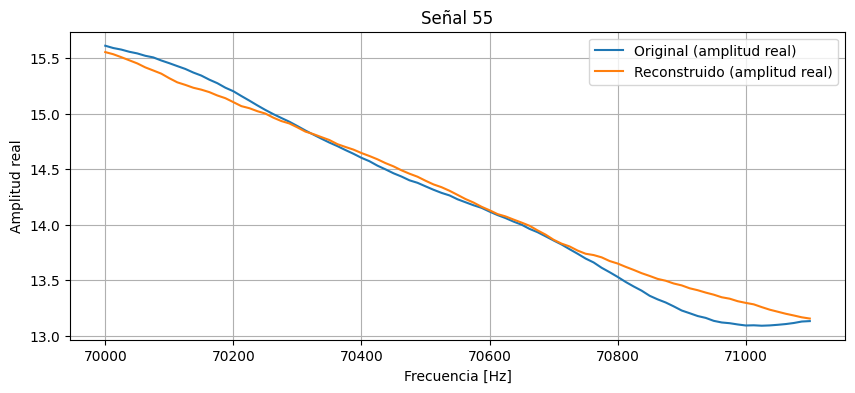

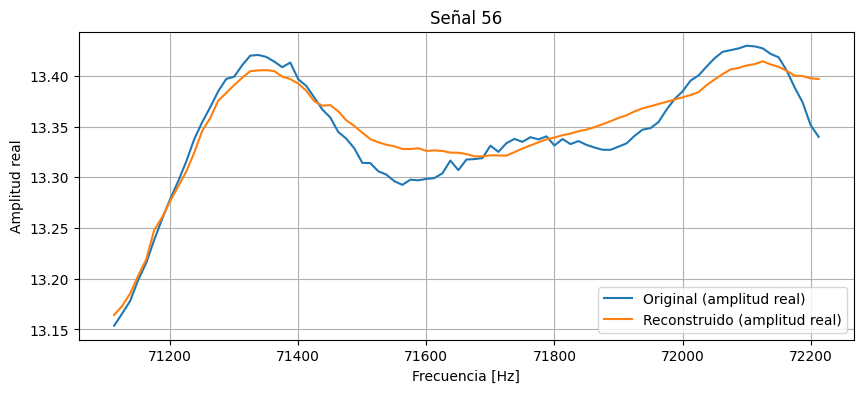

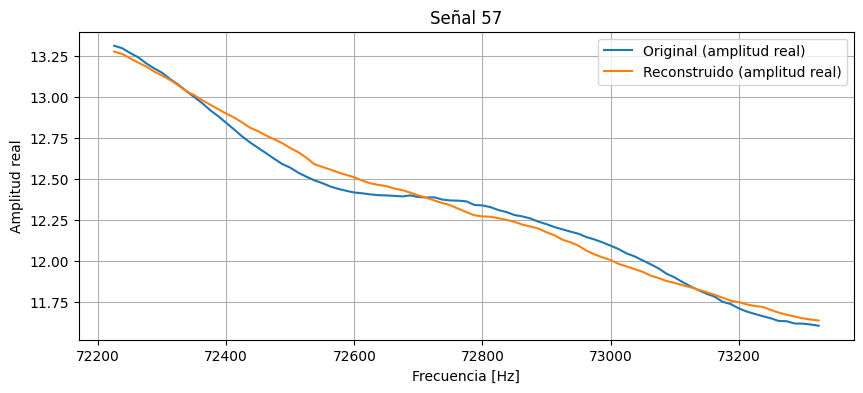

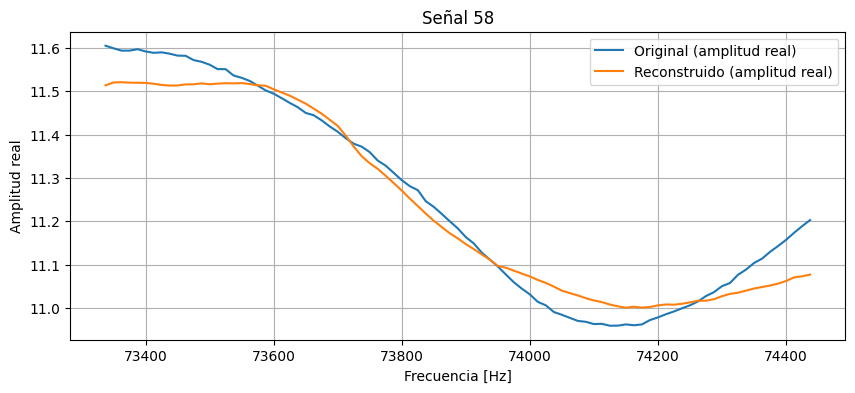

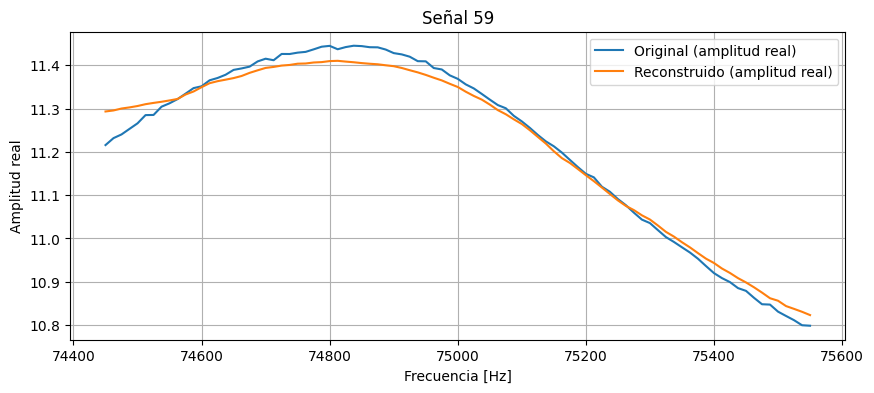

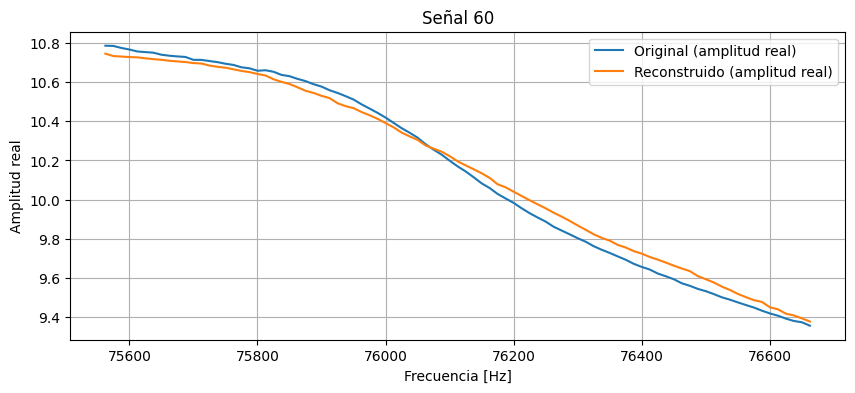

In [33]:
def evaluate_test_signals(model, test_data_scaled, test_data_real, freqs_tensor):
    model.eval()
    with torch.no_grad():
        for i, (scaled_signal, real_signal) in enumerate(zip(test_data_scaled[:60], test_data_real[:60])):
            # Índices para extraer el bloque de frecuencias de esta señal
            start_idx = i * real_signal.shape[-1]  # i * 89
            end_idx = start_idx + real_signal.shape[-1]
            freqs_signal = freqs_tensor[start_idx:end_idx]  # [89]

            # Paso por el modelo con la señal normalizada
            input_tensor = scaled_signal.unsqueeze(0)  # [1, 1, 89]
            reconstructed_scaled = model(input_tensor)[0].squeeze().detach()  # [89]

            # Des-normalización usando min y max de la señal real correspondiente
            min_val = real_signal.min()
            max_val = real_signal.max()
            reconstructed_real = reconstructed_scaled * (max_val - min_val) + min_val

            # Graficar
            plt.figure(figsize=(10, 4))
            plt.plot(freqs_signal, real_signal.squeeze().numpy(), label='Original (amplitud real)')
            plt.plot(freqs_signal, reconstructed_real.numpy(), label='Reconstruido (amplitud real)')
            plt.title(f"Señal {i+1}")
            plt.legend()
            plt.xlabel("Frecuencia [Hz]")
            plt.ylabel("Amplitud real")
            plt.grid(True)
            plt.show()

# Ejemplo de uso
evaluate_test_signals(model, data_scaled, loads, freqs_tensor)